In [1]:
%load_ext watermark
%watermark -a 'Christian Schuhegger' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,qgrid,rpy2,libpgm,pgmpy,networkx,graphviz,pybnl,pytest

Christian Schuhegger 
last updated: 2018-07-11 

CPython 3.6.4
IPython 6.2.1

numpy 1.14.2
xarray 0.10.3
scipy 1.0.1
pandas 0.22.0
sklearn 0.19.1
matplotlib 2.2.2
seaborn 0.8.1
qgrid 1.0.2
rpy2 2.9.1
libpgm n
pgmpy n
networkx 2.1
graphviz 0.8.3
pybnl n
pytest 3.5.0


In [2]:
%matplotlib inline
import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt, seaborn as sns
import sklearn, sklearn.pipeline, sklearn.model_selection, sklearn.naive_bayes
import networkx as nx, graphviz, networkx.algorithms.dag
import random
import itertools, collections
import tqdm
import warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [196]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
%load_ext autoreload
%autoreload 1
%aimport pybnl.bn

In [6]:
%aimport dsbasics.bin

In [7]:
import locale
locale.setlocale(locale.LC_ALL, 'C')

import rpy2, rpy2.rinterface, rpy2.robjects, rpy2.robjects.packages, rpy2.robjects.lib, rpy2.robjects.lib.grid, \
    rpy2.robjects.lib.ggplot2, rpy2.robjects.pandas2ri, rpy2.interactive.process_revents, \
    rpy2.interactive, rpy2.robjects.lib.grdevices
# rpy2.interactive.process_revents.start()
rpy2.robjects.pandas2ri.activate()

In [8]:
rpackageversionfn = rpy2.robjects.r('packageVersion')
print(rpackageversionfn("bnlearn")[0])
print(rpackageversionfn("gRain")[0])

[1]        4        4 20180620

[1] 1 3 0



# House Prices in Ames, Iowa

* [Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf)
  * [AmesResidential.pdf](https://ww2.amstat.org/publications/jse/v19n3/decock/AmesResidential.pdf)
  * [DataDocumentation.txt](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt)
  * [AmesHousing.txt](https://ww2.amstat.org/publications/jse/v19n3/decock/AmesHousing.txt)
  * [AmesHousing.xls](http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls)
  * Also on [kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

The below example reproduces the example from chapter 5 (page 79) in [Bayesian Networks and BayesiaLab: A Practical Introduction for Researchers](https://www.amazon.com/Bayesian-Networks-BayesiaLab-Introduction-Researchers/dp/0996533303).

## Approach

The overall approach below is to first go through the data manually to convert it into the correct shape to be valid as input for a bayesian network. This is quite involved an takes a large part of this document:

[Manual Steps](#section-manual-steps)

Next we use the data that results from the manual transformations and create three different naive bayes classifiers:

* [naive bayes classifier](#section-manual-naive-bayes-classifier)
  * [bnlearn by hand](#section-manual-naive-bayes-classifier-bnlearn-by-hand)
  * [bnlearn via naive.bayes](#section-manual-naive-bayes-classifier-bnlearn-via-naive-bayes)
  * [sklearn via MultinomialNB](#section-manual-naive-bayes-classifier-sklearn-multinomialnb)

After seeing how all of the steps work when we do them manually in "slow motion" let's shift gear and automate the process via:

* [sklearn pipelines](#section-sklearn-pipeline)
  * [raw data transform](#section-sklearn-pipeline-data-transform)
  * [pipeline with bnlearn naive.bayes](#section-sklearn-pipeline-bnlearn)
  * [pay attention to dataframes containing categories; they are tricky!](#section-sklearn-pipeline-attention-to-categories)
  * [scoring and scores](#section-scoring-and-scores)
  * [sklearn end-to-end pipeline with predicted y values (regression)](#section-sklearn-pipeline-bnlearn-regression)
  * [sklearn end-to-end pipeline with predicted y values (regression) with the sklearn.naive_bayes.MultinomialNB ](#section-sklearn-pipeline-sklearn-regression)
 

Now that we have automated the pipeline we can also do cross validation:
* [cross-validation](#section-cross-validation)


And in order to get an idea about how well our naive bayesian model does in comparison to other approaches let's compare it to Random Forest Regression:
* [Tree / Random Forest Regression](#section-tree-random-forest-regression)

In [9]:
df = pd.read_csv('./AmesHousing.txt.gz', sep='\t', index_col=0)
df['MS SubClass'] = df['MS SubClass'].apply(lambda x: '{0:0>3}'.format(x))
df.iloc[:5,:15]

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2
Order,,,,,,,,,,,,,,,
1,526301100,020,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm
2,526350040,020,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm
3,526351010,020,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm
4,526353030,020,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm
5,527105010,060,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm


In [10]:
df.columns

Index(['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Wood D

<a id='section-manual-steps'></a>

## Manual Steps

In [11]:
discrete_non_null, discrete_with_null, continuous_non_null, continuous_with_null, levels_map = pybnl.bn.discrete_and_continuous_variables_with_and_without_nulls(df, cutoff=30)
# discrete_non_null, discrete_with_null, continuous_non_null, continuous_with_null, levels_map

In [12]:
ddf = df.copy()
#cat_columns = ['Alley', 'Bedroom AbvGr', 'Bldg Type', 'Bsmt Cond', ]
cat_columns = [
    'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
    'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type', 'Sale Condition'
] + [
    'Overall Qual', 'Overall Cond'
]
cat_columns_ordinal = [
    ('Lot Shape',      ['Reg','IR1','IR2','IR3']),
    ('Utilities',      ['AllPub','NoSewr','NoSeWa','ELO']),
    ('Land Slope',     ['Gtl', 'Mod', 'Sev']),
    ('Exter Qual',     ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Exter Cond',     ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Bsmt Qual',      ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Bsmt Cond',      ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Bsmt Exposure',  ['Gd', 'Av', 'Mn', 'No', 'NA']),
    ('BsmtFin Type 1', ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']),
    ('BsmtFin Type 2', ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']),
    ('Heating QC',     ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Electrical',     ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']),
    ('Kitchen Qual',   ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Functional',     ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal']),
    ('Fireplace Qu',   ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Garage Finish',  ['Fin', 'RFn', 'Unf', 'NA']),
    ('Garage Qual',    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Garage Cond',    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Paved Drive',    ['Y', 'P', 'N']),
    ('Pool QC',        ['Ex', 'Gd', 'TA', 'Fa', 'NA']),
    ('Fence',          ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA']),
]

continuous_columns = [
    'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
    'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice'
]
discrete_columns = ['Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Mo Sold', 'Yr Sold', 'Bedroom AbvGr', 'Kitchen AbvGr']# do not exist: 'Bedroom',  'Kitchen'

for col in cat_columns:
    levels = levels_map[col]
    # print('col: {}'.format(col))
    # if all([isinstance(level, (int, float)) for level in levels]):
    if all([np.issubdtype(type(level), np.number) for level in levels]):
        # print('int, float column: {}'.format(col))
        levels = sorted(levels)
        ddf[col] = df[col].astype(pd.api.types.CategoricalDtype(levels, ordered=True))
    else:
        ddf[col] = df[col].astype(pd.api.types.CategoricalDtype(levels, ordered=False))

for col, levels in cat_columns_ordinal:
    ddf[col] = df[col].astype(pd.api.types.CategoricalDtype(levels[::-1], ordered=True))

for col in continuous_columns:
    ddf[col] = df[col].astype(float)

for col in discrete_columns:
    if pd.isnull(df[col]).any():
        ddf[col] = df[col].astype(float)
    else:
        ddf[col] = df[col].astype(int)
    
# col   = 'Alley'
# ddf[col]
# ddf[~pd.isnull(ddf[col])][col]
# value = np.nan
# ddf.loc[df[col]==value,col]

[Working with Pandas: Fixing messy column names](https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd)

In [13]:
ddf.columns = ddf.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [14]:
type(ddf.columns)

pandas.core.indexes.base.Index

In [15]:
ddf.head()

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,020,RL,141.0,31770.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656.0,0.0,0.0,1656.0,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210.0,62.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,5,2010,WD,Normal,215000.0
2,526350040,020,RH,80.0,11622.0,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896.0,0.0,0.0,896.0,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140.0,0.0,0.0,0.0,120.0,0.0,NaN,MnPrv,NaN,0.0,6,2010,WD,Normal,105000.0
3,526351010,020,RL,81.0,14267.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329.0,0.0,0.0,1329.0,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393.0,36.0,0.0,0.0,0.0,0.0,NaN,NaN,Gar2,12500.0,6,2010,WD,Normal,172000.0
4,526353030,020,RL,93.0,11160.0,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110.0,0.0,0.0,2110.0,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,4,2010,WD,Normal,244000.0
5,527105010,060,RL,74.0,13830.0,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928.0,701.0,0.0,1629.0,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212.0,34.0,0.0,0.0,0.0,0.0,NaN,MnPrv,NaN,0.0,3,2010,WD,Normal,189900.0


In [16]:
# ddf.to_hdf('AmesHousing.h5', 'AmesHousing',format='table', append=False)

In [17]:
# pd.read_hdf('AmesHousing.h5', 'AmesHousing').head()

## Treating Filtered Values ('FV')

See page 84 in "Bayesian Networks and BayesiaLab"

### Bsmt fields

In [18]:
bsmt_fields_ = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Full Bath', 'Bsmt Half Bath', 
               'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']
bsmt_fields = pd.Index(bsmt_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf[bsmt_fields].query('Bsmt_Qual == "NA"')
# ddf[ddf['Bsmt_Qual'] == 'NA'][bsmt_fields]
# df[bsmt_fields_][df['Bsmt Qual'] == 'NA']

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,


It seems that there are no filtered values for 'Bsmt' fields, e.g. each home contains a basement.

[Querying for NaN and other names in Pandas](https://stackoverflow.com/questions/26535563/querying-for-nan-and-other-names-in-pandas)

In [19]:
ddf[bsmt_fields][pd.isnull(ddf.Bsmt_Qual)].head()

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,
84,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
155,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
207,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
244,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
274,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df[bsmt_fields_][pd.isnull(df['Bsmt Qual'])].head()

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Bsmt Full Bath,Bsmt Half Bath,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF
Order,,,,,,,,,,,
84,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
155,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
207,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
244,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
274,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


But there are quite a lot of 'NaN' entries. Not sure why the data description contains an "NA" value as "No Basement", but no actual data-set uses it. Most likely these values are supposed to be "NA"

In [21]:
ddf[bsmt_fields][pd.isnull(ddf.Bsmt_Qual) & ~pd.isnull(ddf.BsmtFin_Type_2)].head()

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,


In [22]:
bsmt_na_fields = ['Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2']
ddf.loc[pd.isnull(ddf.Bsmt_Qual), bsmt_na_fields] = "NA"
ddf[bsmt_fields].query('Bsmt_Qual == "NA"').head()

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,
84,NA,NA,NA,NA,NA,0.0,0.0,0.0,0.0,0.0,0.0
155,NA,NA,NA,NA,NA,0.0,0.0,0.0,0.0,0.0,0.0
207,NA,NA,NA,NA,NA,0.0,0.0,0.0,0.0,0.0,0.0
244,NA,NA,NA,NA,NA,0.0,0.0,0.0,0.0,0.0,0.0
274,NA,NA,NA,NA,NA,0.0,0.0,0.0,0.0,0.0,0.0


### Electrical field

In [23]:
ddf.Electrical.value_counts(dropna=False)

SBrkr    2682
FuseA     188
FuseF      50
FuseP       8
NaN         1
Mix         1
Name: Electrical, dtype: int64

In [24]:
ddf[pd.isnull(ddf.Electrical)]

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1578,916386080,080,RL,73.0,9735.0,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,NaN,754.0,640.0,0.0,1394.0,0.0,0.0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,5,2008,WD,Normal,167500.0


The one NaN value seems to be a missing value

### Fireplaces

In [25]:
fireplaces_fields_ = ['Fireplaces', 'Fireplace Qu']
fireplaces_fields = pd.Index(fireplaces_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf[fireplaces_fields].query('Fireplaces == 0').head()

,Fireplaces,Fireplace_Qu
Order,,
2,0,NaN
3,0,NaN
7,0,NaN
8,0,NaN
12,0,NaN


In [26]:
ddf.loc[ddf.Fireplaces == 0,['Fireplace_Qu']] = 'NA'
ddf[fireplaces_fields].query('Fireplaces == 0').head()

,Fireplaces,Fireplace_Qu
Order,,
2,0,NA
3,0,NA
7,0,NA
8,0,NA
12,0,NA


### Garage fields

In [27]:
garage_fields_ = ['Garage Type', 'Garage Finish', 'Garage Cars', 'Garage Qual', 'Garage Cond', 'Garage Yr Blt', 'Garage Area']
garage_fields = pd.Index(garage_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf[garage_fields][pd.isnull(ddf.Garage_Type)].head()

,Garage_Type,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Garage_Yr_Blt,Garage_Area
Order,,,,,,,
28,NaN,NaN,0.0,NaN,NaN,NaN,0.0
120,NaN,NaN,0.0,NaN,NaN,NaN,0.0
126,NaN,NaN,0.0,NaN,NaN,NaN,0.0
130,NaN,NaN,0.0,NaN,NaN,NaN,0.0
131,NaN,NaN,0.0,NaN,NaN,NaN,0.0


In [28]:
ddf['Garage_Type'] = ddf['Garage_Type'].astype(str)\
    .astype(pd.api.types.CategoricalDtype(set(list(ddf.Garage_Type.dtype.categories) + ['NA'])))
ddf.Garage_Type.dtype.categories

Index(['Detchd', 'Basment', 'CarPort', 'BuiltIn', '2Types', 'NA', 'Attchd'], dtype='object')

In [29]:
ddf.loc[pd.isnull(ddf.Garage_Type),['Garage_Type', 'Garage_Finish', 'Garage_Qual', 'Garage_Cond']] = 'NA'
ddf.loc[ddf.Garage_Type == 'NA',['Garage_Yr_Blt']] = -1.0
#ddf[garage_fields][pd.isnull(ddf.Garage_Yr_Blt)]
#ddf['Garage_Yr_Blt'] = ddf['Garage_Yr_Blt'].astype(int)
ddf[garage_fields][ddf.Garage_Type == 'NA'].head()

,Garage_Type,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Garage_Yr_Blt,Garage_Area
Order,,,,,,,
28,NA,NA,0.0,NA,NA,-1.0,0.0
120,NA,NA,0.0,NA,NA,-1.0,0.0
126,NA,NA,0.0,NA,NA,-1.0,0.0
130,NA,NA,0.0,NA,NA,-1.0,0.0
131,NA,NA,0.0,NA,NA,-1.0,0.0


### Mas Vnr fields

In [30]:
mas_vnr_fields_ = ['Mas Vnr Type', 'Mas Vnr Area']
mas_vnr_fields = pd.Index(mas_vnr_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf[mas_vnr_fields][pd.isnull(ddf.Mas_Vnr_Type)].head()

,Mas_Vnr_Type,Mas_Vnr_Area
Order,,
56,NaN,NaN
485,NaN,NaN
518,NaN,NaN
539,NaN,NaN
868,NaN,NaN


In [31]:
ddf[mas_vnr_fields][(ddf.Mas_Vnr_Type == 'None') & (ddf.Mas_Vnr_Area != 0.0)]

,Mas_Vnr_Type,Mas_Vnr_Area
Order,,
364,None,344.0
404,None,312.0
442,None,285.0
1862,None,1.0
1914,None,1.0
2004,None,1.0
2529,None,288.0


In [32]:
ddf.Mas_Vnr_Type.dtype

CategoricalDtype(categories=['None', 'CBlock', 'BrkCmn', 'BrkFace', 'Stone'], ordered=False)

In [33]:
ddf.loc[pd.isnull(ddf.Mas_Vnr_Type), ['Mas_Vnr_Type']] = 'None'
# ddf.loc[ddf.Mas_Vnr_Type == 'None', ['Mas_Vnr_Area']] = 0.0

In [34]:
ddf.loc[pd.isnull(ddf.Mas_Vnr_Area), ['Mas_Vnr_Area']] = 0.0

In [35]:
ddf[mas_vnr_fields][ddf.Mas_Vnr_Type == 'None'].head()

,Mas_Vnr_Type,Mas_Vnr_Area
Order,,
2,None,0.0
4,None,0.0
5,None,0.0
7,None,0.0
8,None,0.0


### Pool fields

In [36]:
pool_fields_ = ['Pool QC', 'Pool Area']
pool_fields = pd.Index(pool_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf[pool_fields][pd.isnull(ddf.Pool_QC)].head()

,Pool_QC,Pool_Area
Order,,
1,NaN,0.0
2,NaN,0.0
3,NaN,0.0
4,NaN,0.0
5,NaN,0.0


In [37]:
ddf.loc[pd.isnull(ddf.Pool_QC), ['Pool_QC']] = 'NA'
ddf[pool_fields][ddf.Pool_QC == 'NA'].head()

,Pool_QC,Pool_Area
Order,,
1,NA,0.0
2,NA,0.0
3,NA,0.0
4,NA,0.0
5,NA,0.0


### Fence field

In [38]:
fence_fields_ = ['Fence']
fence_fields = pd.Index(fence_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf.loc[pd.isnull(ddf.Fence), ['Fence']] = 'NA'
ddf[fence_fields][ddf.Fence == 'NA'].head()

,Fence
Order,
1,NA
3,NA
4,NA
6,NA
7,NA


### Misc Feature field

In [39]:
misc_feature_fields_ = ['Misc Feature']
misc_feature_fields = pd.Index(misc_feature_fields_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
ddf['Misc_Feature'] = ddf['Misc_Feature'].astype(str)\
    .astype(pd.api.types.CategoricalDtype(set(list(ddf.Misc_Feature.dtype.categories) + ['NA'])))
ddf.loc[pd.isnull(ddf.Misc_Feature), ['Misc_Feature']] = 'NA'
ddf[misc_feature_fields][ddf.Misc_Feature == 'NA'].head()

,Misc_Feature
Order,
1,NA
2,NA
4,NA
5,NA
6,NA


### Check remaining nan fields

In [40]:
_, discrete_with_null_, _, continuous_with_null_, _ = pybnl.bn.discrete_and_continuous_variables_with_and_without_nulls(ddf, cutoff=30)
discrete_with_null_, continuous_with_null_

(['Alley',
  'Bsmt_Exposure',
  'BsmtFin_Type_2',
  'Electrical',
  'Bsmt_Full_Bath',
  'Bsmt_Half_Bath',
  'Garage_Finish',
  'Garage_Cars',
  'Garage_Qual',
  'Garage_Cond'],
 ['Lot_Frontage',
  'BsmtFin_SF_1',
  'BsmtFin_SF_2',
  'Bsmt_Unf_SF',
  'Total_Bsmt_SF',
  'Garage_Yr_Blt',
  'Garage_Area'])

In [41]:
ddf[bsmt_fields][pd.isnull(ddf.Bsmt_Exposure)]

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,
67,Gd,TA,NaN,Unf,Unf,0.0,0.0,0.0,0.0,1595.0,1595.0
1797,Gd,TA,NaN,Unf,Unf,0.0,0.0,0.0,0.0,725.0,725.0
2780,Gd,TA,NaN,Unf,Unf,0.0,0.0,0.0,0.0,936.0,936.0


Just set the few NaN values to 'No'

In [42]:
ddf.loc[pd.isnull(ddf.Bsmt_Exposure),['Bsmt_Exposure']] = 'No'

In [43]:
ddf[bsmt_fields][pd.isnull(ddf.BsmtFin_Type_2)]

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,
445,Gd,TA,No,GLQ,NaN,1.0,0.0,1124.0,479.0,1603.0,3206.0


Just set the few NaN values to 'Unf'

In [44]:
ddf.loc[pd.isnull(ddf.BsmtFin_Type_2),['BsmtFin_Type_2']] = 'NA'

In [45]:
ddf[bsmt_fields][pd.isnull(ddf.Bsmt_Full_Bath)]

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,
1342,NA,NA,NA,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN
1498,NA,NA,NA,NA,NA,NaN,NaN,0.0,0.0,0.0,0.0


In [46]:
ddf[bsmt_fields][pd.isnull(ddf.Bsmt_Half_Bath)]

,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Full_Bath,Bsmt_Half_Bath,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF
Order,,,,,,,,,,,
1342,NA,NA,NA,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN
1498,NA,NA,NA,NA,NA,NaN,NaN,0.0,0.0,0.0,0.0


Just set all the NaN values to 0.0

In [47]:
ddf.loc[pd.isnull(ddf.Bsmt_Full_Bath),['Bsmt_Full_Bath','Bsmt_Half_Bath','BsmtFin_SF_1','BsmtFin_SF_2','Bsmt_Unf_SF','Total_Bsmt_SF']] = [0.0,0.0,0.0,0.0,0.0,0.0]

In [48]:
ddf[['Electrical']][pd.isnull(ddf.Electrical)]

,Electrical
Order,
1578,NaN


Just set this single NaN value to 'Mix'

In [49]:
ddf.loc[pd.isnull(ddf.Electrical),['Electrical']] = 'Mix'

The remaining NaN garage fields seem to be really missing values so don't touch them.

In [50]:
ddf[garage_fields][pd.isnull(ddf.Garage_Finish)]

,Garage_Type,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Garage_Yr_Blt,Garage_Area
Order,,,,,,,
1357,Detchd,NaN,1.0,NaN,NaN,NaN,360.0
2237,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
ddf[garage_fields][pd.isnull(ddf.Garage_Cars)]

,Garage_Type,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Garage_Yr_Blt,Garage_Area
Order,,,,,,,
2237,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
ddf[garage_fields][pd.isnull(ddf.Garage_Qual)]

,Garage_Type,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Garage_Yr_Blt,Garage_Area
Order,,,,,,,
1357,Detchd,NaN,1.0,NaN,NaN,NaN,360.0
2237,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
ddf[garage_fields][pd.isnull(ddf.Garage_Cond)]

,Garage_Type,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Garage_Yr_Blt,Garage_Area
Order,,,,,,,
1357,Detchd,NaN,1.0,NaN,NaN,NaN,360.0
2237,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


The Lot_Frontage NaN fields seem to be really missing values so don't touch them.

In [54]:
ddf[pd.isnull(ddf.Lot_Frontage)].head()

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12,527165230,020,RL,NaN,7980.0,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,PConc,Gd,TA,No,ALQ,935.0,Unf,0.0,233.0,1168.0,GasA,Ex,Y,SBrkr,1187.0,0.0,0.0,1187.0,1.0,0.0,2,0,3,1,TA,6,Typ,0,NA,Attchd,1992.0,Fin,2.0,420.0,TA,TA,Y,483.0,21.0,0.0,0.0,0.0,0.0,NA,GdPrv,Shed,500.0,3,2010,WD,Normal,185000.0
15,527182190,120,RL,NaN,6820.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1985,1985,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,368.0,BLQ,1120.0,0.0,1488.0,GasA,TA,Y,SBrkr,1502.0,0.0,0.0,1502.0,1.0,0.0,1,1,1,1,Gd,4,Typ,0,NA,Attchd,1985.0,RFn,2.0,528.0,TA,TA,Y,0.0,54.0,0.0,0.0,140.0,0.0,NA,NA,NA,0.0,6,2010,WD,Normal,212000.0
23,527368020,060,FV,NaN,7500.0,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,533.0,Unf,0.0,281.0,814.0,GasA,Ex,Y,SBrkr,814.0,860.0,0.0,1674.0,1.0,0.0,2,1,3,1,Gd,7,Typ,0,NA,Attchd,2000.0,RFn,2.0,663.0,TA,TA,Y,0.0,96.0,0.0,0.0,0.0,0.0,NA,NA,NA,0.0,1,2010,WD,Normal,216000.0
24,527402200,020,RL,NaN,11241.0,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578.0,Unf,0.0,426.0,1004.0,GasA,Ex,Y,SBrkr,1004.0,0.0,0.0,1004.0,1.0,0.0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2.0,480.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NA,NA,Shed,700.0,3,2010,WD,Normal,149000.0
25,527402250,020,RL,NaN,12537.0,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1971,2008,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,GLQ,734.0,Unf,0.0,344.0,1078.0,GasA,Ex,Y,SBrkr,1078.0,0.0,0.0,1078.0,1.0,0.0,1,1,3,1,TA,6,Typ,1,Fa,Attchd,1971.0,Fin,2.0,500.0,TA,TA,Y,0.0,0.0,0.0,0.0,0.0,0.0,NA,NA,NA,0.0,4,2010,WD,Normal,149900.0


In [55]:
_, discrete_with_null_, _, continuous_with_null_, _ = pybnl.bn.discrete_and_continuous_variables_with_and_without_nulls(ddf, cutoff=30)
discrete_with_null_, continuous_with_null_

(['Alley', 'Garage_Finish', 'Garage_Cars', 'Garage_Qual', 'Garage_Cond'],
 ['Lot_Frontage', 'Garage_Yr_Blt', 'Garage_Area'])

## Binning / Discretization

In [56]:
ddf1 = ddf.copy()

### The target variable is SalePrice

In [57]:
ddf.SalePrice.describe()

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [58]:
ddf1.SalePrice = pd.cut(ddf.SalePrice, [0.0,75000.0, 150000.0, 225000.0, 300000.0,np.PINF], right=False)
ddf1['SalePrice'].value_counts()

[75000.0, 150000.0)     1195
[150000.0, 225000.0)    1043
[225000.0, 300000.0)     396
[300000.0, inf)          238
[0.0, 75000.0)            58
Name: SalePrice, dtype: int64

### Continuous, discrete and ordinal variables

In [59]:
continuous_columns_without_sale_price = list(set(continuous_columns) - set(['SalePrice']))

In [60]:
target_variable_decision_tree_binning_variables_ = [c for c,r in cat_columns_ordinal] + continuous_columns_without_sale_price + discrete_columns + ['Overall Qual', 'Overall Cond']
target_variable_decision_tree_binning_variables = pd.Index(target_variable_decision_tree_binning_variables_).str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
target_variable_decision_tree_binning_variables

Index(['Lot_Shape', 'Utilities', 'Land_Slope', 'Exter_Qual', 'Exter_Cond', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating_QC', 'Electrical', 'Kitchen_Qual', 'Functional', 'Fireplace_Qu', 'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Pool_QC', 'Fence', 'Misc_Val', 'Gr_Liv_Area', 'Screen_Porch', 'Bsmt_Unf_SF', 'BsmtFin_SF_1', 'Wood_Deck_SF', 'Low_Qual_Fin_SF', '1st_Flr_SF', 'Pool_Area', 'Garage_Area', 'Open_Porch_SF', 'Mas_Vnr_Area', 'Lot_Area', '3Ssn_Porch', 'BsmtFin_SF_2', 'Total_Bsmt_SF', '2nd_Flr_SF', 'Lot_Frontage', 'Enclosed_Porch', 'Year_Built', 'Year_Remod/Add', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'TotRms_AbvGrd', 'Fireplaces', 'Garage_Yr_Blt', 'Garage_Cars', 'Mo_Sold', 'Yr_Sold', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'Overall_Qual', 'Overall_Cond'], dtype='object')

In [61]:
tmp_ddf_before_binning = ddf.copy()

In [62]:
tvbt = dsbasics.bin.TargetVariableDecisionTreeBinTransformer0(max_leaf_nodes=3)
ddf1.loc[:,target_variable_decision_tree_binning_variables] = \
    tvbt.fit_transform(ddf[target_variable_decision_tree_binning_variables], ddf1.SalePrice)
ddf1.head()

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,020,RL,"[81.5, inf)","[10532.5, inf)",Pave,NaN,[IR1],Lvl,[AllPub],Corner,[Gtl],NAmes,Norm,Norm,1Fam,1Story,"[1,2,3,4,5,6]",[5],"[-inf, 1984.5)","[-inf, 1985.5)",Hip,CompShg,BrkFace,Plywood,Stone,"[2.0, 183.5)","[Po,Fa,TA]",[TA],CBlock,"[NA,Po,Fa,TA]","[Gd,Ex]",[Gd],"[Unf,LwQ,Rec,BLQ,ALQ]","[-inf, 982.5)",[Unf],"[-inf, 3.0)","[28.5, 1042.5)","[-inf, 1217.5)",GasA,"[Po,Fa,TA]",Y,[SBrkr],"[1389.5, inf)","[-inf, 813.5)","[-inf, 66.5)","[1488.5, 1969.5)","[0.5, 1.5)","[-inf, 0.5)","[-inf, 1.5)","[-inf, 0.5)","[2.5, 3.5)","[0.5, 1.5)","[Po,Fa,TA]","[6.5, 8.5)",[Typ],"[1.5, inf)","[TA,Gd]",Attchd,"[-inf, 1987.5)",[Fin],"[1.5, 2.5)","[387.0, 627.5)",[TA],"[TA,Gd]",[P],"[155.5, inf)","[30.5, inf)","[-inf, 17.0)","[-inf, 151.5)","[-inf, 136.5)","[-inf, 72.0)",[NA],[NA],NA,"[-inf, 27.0)","[1.5, 5.5)","[2009.5, inf)",WD,Normal,"[150000.0, 225000.0)"
2,526350040,020,RH,"[71.5, 81.5)","[10532.5, inf)",Pave,NaN,[Reg],Lvl,[AllPub],Inside,[Gtl],NAmes,Feedr,Norm,1Fam,1Story,"[1,2,3,4,5,6]","[6,7,8,9]","[-inf, 1984.5)","[-inf, 1985.5)",Gable,CompShg,VinylSd,VinylSd,None,"[-inf, 2.0)","[Po,Fa,TA]",[TA],CBlock,"[NA,Po,Fa,TA]",[TA],"[NA,No,Mn]","[Unf,LwQ,Rec,BLQ,ALQ]","[-inf, 982.5)","[LwQ,Rec,BLQ,ALQ,GLQ]","[3.0, 964.0)","[28.5, 1042.5)","[-inf, 1217.5)",GasA,"[Po,Fa,TA]",Y,[SBrkr],"[-inf, 1078.5)","[-inf, 813.5)","[-inf, 66.5)","[-inf, 1488.5)","[-inf, 0.5)","[-inf, 0.5)","[-inf, 1.5)","[-inf, 0.5)","[-inf, 2.5)","[0.5, 1.5)","[Po,Fa,TA]","[-inf, 6.5)",[Typ],"[-inf, 0.5)","[NA,Po,Fa]",Attchd,"[-inf, 1987.5)","[NA,Unf]","[-inf, 1.5)","[627.5, inf)",[TA],"[TA,Gd]",[Y],"[96.5, 155.5)","[-inf, 11.5)","[-inf, 17.0)","[-inf, 151.5)","[-inf, 136.5)","[-inf, 72.0)",[NA],"[MnWw,GdWo,MnPrv]",NA,"[-inf, 27.0)","[5.5, inf)","[2009.5, inf)",WD,Normal,"[75000.0, 150000.0)"
3,526351010,020,RL,"[71.5, 81.5)","[10532.5, inf)",Pave,NaN,[IR1],Lvl,[AllPub],Corner,[Gtl],NAmes,Norm,Norm,1Fam,1Story,"[1,2,3,4,5,6]","[6,7,8,9]","[-inf, 1984.5)","[-inf, 1985.5)",Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,"[2.0, 183.5)","[Po,Fa,TA]",[TA],CBlock,"[NA,Po,Fa,TA]",[TA],"[NA,No,Mn]","[Unf,LwQ,Rec,BLQ,ALQ]","[-inf, 982.5)",[Unf],"[-inf, 3.0)","[28.5, 1042.5)","[1217.5, 1681.0)",GasA,"[Po,Fa,TA]",Y,[SBrkr],"[1078.5, 1389.5)","[-inf, 813.5)","[-inf, 66.5)","[-inf, 1488.5)","[-inf, 0.5)","[-inf, 0.5)","[-inf, 1.5)","[0.5, 1.5)","[2.5, 3.5)","[0.5, 1.5)",[Gd],"[-inf, 6.5)",[Typ],"[-inf, 0.5)","[NA,Po,Fa]",Attchd,"[-inf, 1987.5)","[NA,Unf]","[-inf, 1.5)","[-inf, 387.0)",[TA],"[TA,Gd]",[Y],"[155.5, inf)","[30.5, inf)","[-inf, 17.0)","[-inf, 151.5)","[-inf, 136.5)","[-inf, 72.0)",[NA],[NA],Gar2,"[1250.0, inf)","[5.5, inf)","[2009.5, inf)",WD,Normal,"[150000.0, 225000.0)"
4,526353030,020,RL,"[81.5, inf)","[10532.5, inf)",Pave,NaN,[Reg],Lvl,[AllPub],Corner,[Gtl],NAmes,Norm,Norm,1Fam,1Story,[7],[5],"[-inf, 1984.5)","[-inf, 1985.5)",Hip,CompShg,BrkFace,BrkFace,None,"[-inf, 2.0)",[Gd],[TA],CBlock,"[NA,Po,Fa,TA]",[TA],"[NA,No,Mn]","[Unf,LwQ,Rec,BLQ,ALQ]","[982.5, 1335.0)",[

In [63]:
len(df.columns),len(ddf1.columns)

(81, 81)

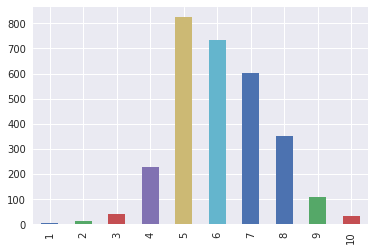

In [64]:
ddf['Overall_Qual'].value_counts().sort_index().plot(kind='bar');

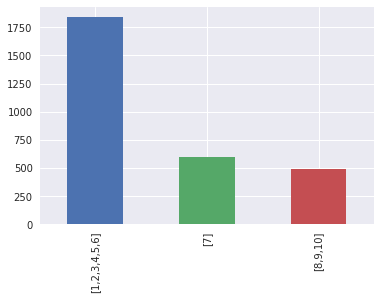

In [65]:
ddf1['Overall_Qual'].value_counts().sort_index().plot(kind='bar');

### Convert interval indices to strings

In [66]:
ddf1 = pybnl.bn.convert_interval_index_categories_to_string_categories(ddf1,inplace=False)

In [67]:
ddf1.Bsmt_Full_Bath.dtype

CategoricalDtype(categories=['[-inf, 0.5)', '[0.5, 1.5)', '[1.5, inf)'], ordered=True)

### Rename columns to fit with R conventions

In [68]:
ddf1 = ddf1.rename(columns={
    "1st_Flr_SF":"X1st_Flr_SF",
    "2nd_Flr_SF":"X2nd_Flr_SF",
    "3Ssn_Porch":"X3Ssn_Porch",
    "Year_Remod/Add":"Year_Remod_Add"
})

### Drop unused columns

In [69]:
if any(ddf1.columns.isin(['PID'])):
    ddf1.drop('PID', axis=1, inplace=True)
# ddf1.columns

#### Drop the 'Alley' column, which contains most null values and will not contribute to the quality of the fit

In [70]:
if any(ddf1.columns.isin(['Alley'])):
    ddf1.drop('Alley', axis=1, inplace=True)
# ddf1.columns

The remaining columns with null values are:

In [71]:
_, discrete_with_null_, _, continuous_with_null_, _ = pybnl.bn.discrete_and_continuous_variables_with_and_without_nulls(ddf1, cutoff=30)
discrete_with_null_, continuous_with_null_

(['Lot_Frontage',
  'Garage_Yr_Blt',
  'Garage_Finish',
  'Garage_Cars',
  'Garage_Area',
  'Garage_Qual',
  'Garage_Cond'],
 [])

The statistics of the NaN values are as follows. Only the column `Lot_Frontage` still has relevant null values, e.g. we could simply filter out the 2 `Garage` rows that contain null values:

In [72]:
display_side_by_side(
    pd.DataFrame(ddf1.Lot_Frontage.value_counts(dropna=False)),
    pd.DataFrame(ddf1.Garage_Yr_Blt.value_counts(dropna=False)),
    pd.DataFrame(ddf1.Garage_Finish.value_counts(dropna=False)),
    pd.DataFrame(ddf1.Garage_Cars.value_counts(dropna=False)),
    pd.DataFrame(ddf1.Garage_Area.value_counts(dropna=False)),
    pd.DataFrame(ddf1.Garage_Qual.value_counts(dropna=False)),
    pd.DataFrame(ddf1.Garage_Cond.value_counts(dropna=False))
)

,Lot_Frontage
"[-inf, 71.5)",1411
"[81.5, inf)",544
NaN,490
"[71.5, 81.5)",485
,Garage_Yr_Blt
"[-inf, 1987.5)",1690
"[1987.5, 2005.5)",912
"[2005.5, inf)",326
NaN,2
,Garage_Finish


In [73]:
null_value_idx = pd.isnull(ddf1.Lot_Frontage) | pd.isnull(ddf1.Garage_Yr_Blt) | pd.isnull(ddf1.Garage_Finish) | \
    pd.isnull(ddf1.Garage_Cars) | pd.isnull(ddf1.Garage_Area) | pd.isnull(ddf1.Garage_Qual) | pd.isnull(ddf1.Garage_Cond)
null_value_idx.value_counts()

False    2438
True      492
dtype: int64

In [74]:
ddf_without_null_values = ddf1[~null_value_idx]

In [75]:
ddf_with_null_values = ddf1

<a id='section-manual-naive-bayes-classifier'></a>

## Naive Bayes Classifier

<a id='section-manual-naive-bayes-classifier-bnlearn-by-hand'></a>

### bnlearn by hand

#### Define net

In [76]:
dg = nx.DiGraph()

dg.add_nodes_from(ddf1.columns.values)

in_vars = ddf1.columns.values[:-1]
out_var = ddf1.columns.values[-1:]
dg.add_edges_from(list(itertools.product(out_var, in_vars)))

In [77]:
ns = pybnl.bn.digraph2netstruct(dg)
# ns.dot()
display(HTML(ns.dot()._repr_svg_()))

In [78]:
nbn1 = pybnl.bn.NetAndDataDiscreteBayesNetwork(ldf=ddf_without_null_values, dg=dg, predict_var='SalePrice')
nbn1.fit();

I restricted N to 20 below to save some time, because the manual predictions are based on exact inference as implemented by the R gRain package, which are slow.

Set N to a large number bigger than the size of the input data (e.g. 5000) to create predictions for all values.

In [79]:
N=20 # restricted to speed up runtime of notebook
y_pred = nbn1.predict(ddf_without_null_values.iloc[:N,:-1])

100%|██████████| 20/20 [00:00<00:00, 29.41it/s]


In [80]:
y_true = ddf_without_null_values.iloc[:N,-1:]

We can look at some metrics like the accuracy score:

In [81]:
sklearn.metrics.accuracy_score(y_true, y_pred)

0.95

And the confusion matrix:

In [82]:
tmp_cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
tmp_cm

array([[13,  0,  0,  1],
       [ 0,  2,  0,  0],
       [ 0,  0,  2,  0],
       [ 0,  0,  0,  2]])

In [83]:
np.diag(tmp_cm).sum()/tmp_cm.sum()

0.95

We can also look at the arc strengths, the relative strength ('rs'), the relative mutual information of the 'from' node ('rmif') and the relative mutual information of the 'to' node ('rmit'): 

In [84]:
nbn1.arc_strength_info().head()

,from,to,strength,rs,rmif,rmit
0,SalePrice,Neighborhood,-1086.172919,1.000000,0.344832,0.153247
1,SalePrice,Overall_Qual,-963.928136,0.887454,0.306023,0.429010
2,SalePrice,Garage_Cars,-814.157718,0.749565,0.258474,0.339345
3,SalePrice,Bsmt_Qual,-780.101563,0.718211,0.247662,0.341725
4,SalePrice,Exter_Qual,-759.623713,0.699358,0.241161,0.392364


The above tells us that the most important input for making predictions is the Neighborhood variable.

In [85]:
nbn1.arc_strength_info().tail()

,from,to,strength,rs,rmif,rmit
73,SalePrice,Land_Slope,-8.583311,0.007902,0.002725,0.018697
74,SalePrice,Bsmt_Half_Bath,-7.907456,0.007280,0.002510,0.014344
75,SalePrice,X3Ssn_Porch,-5.215486,0.004802,0.001656,0.040316
76,SalePrice,Utilities,-3.819061,0.003516,0.001212,0.434047
77,SalePrice,Yr_Sold,-3.369036,0.003102,0.001070,0.001417


In [86]:
display(HTML(nbn1.dot()._repr_svg_()))

<a id='section-manual-naive-bayes-classifier-bnlearn-via-naive-bayes'></a>

### bnlearn via naive.bayes

In [87]:
mbn = pybnl.bn.MultinomialNB()
mbn.fit(ddf_without_null_values[in_vars], ddf_without_null_values[out_var[0]])

MultinomialNB()

In [88]:
mbn.arc_strength_info().head()

,from,to,strength,rs,rmif,rmit
0,SalePrice,Neighborhood,-1086.172919,1.000000,0.344832,0.153247
1,SalePrice,Overall_Qual,-963.928136,0.887454,0.306023,0.429010
2,SalePrice,Garage_Cars,-814.157718,0.749565,0.258474,0.339345
3,SalePrice,Bsmt_Qual,-780.101563,0.718211,0.247662,0.341725
4,SalePrice,Exter_Qual,-759.623713,0.699358,0.241161,0.392364


In [89]:
# display(HTML(mbn.dot()._repr_svg_()))

### Predicted vs. real

In [90]:
mbn_predict_df = pd.DataFrame(
    collections.OrderedDict([
        ('predicted', mbn.predict(ddf_without_null_values[in_vars])),
        ('actual', ddf_without_null_values[out_var[0]]),
]))
mbn_predict_df.head()

,predicted,actual
Order,,
1,"[150000.0, 225000.0)","[150000.0, 225000.0)"
2,"[75000.0, 150000.0)","[75000.0, 150000.0)"
3,"[75000.0, 150000.0)","[150000.0, 225000.0)"
4,"[225000.0, 300000.0)","[225000.0, 300000.0)"
5,"[150000.0, 225000.0)","[150000.0, 225000.0)"


In [91]:
mbn.predict_proba(ddf_without_null_values[in_vars]).head()

,"[0.0, 75000.0)","[75000.0, 150000.0)","[150000.0, 225000.0)","[225000.0, 300000.0)","[300000.0, inf)"
Order,,,,,
1,0.000000e+00,1.454981e-04,0.999819,0.000035,0.000000e+00
2,1.372693e-07,9.999978e-01,0.000002,0.000000,0.000000e+00
3,0.000000e+00,9.181823e-01,0.081818,0.000000,0.000000e+00
4,0.000000e+00,5.455605e-09,0.031785,0.968206,8.903248e-06
5,0.000000e+00,7.620312e-13,0.999257,0.000743,3.709000e-13


### Predicted vs. real with probabilities

In [92]:
mbn_predict_with_probabilities_actual_probability_ds = \
    pd.Series(mbn.predict_proba(
        ddf_without_null_values[in_vars]
    ).values[
        np.array(range(len(ddf_without_null_values))).reshape(-1,1),
        ddf_without_null_values[out_var[0]].values.codes.reshape(-1,1)
    ].reshape(-1))
mbn_predict_with_probabilities_actual_probability_ds.index = ddf_without_null_values[in_vars].index
    
mbn_predict_with_probabilities_df = pd.DataFrame(
    collections.OrderedDict([
        ('predicted',             mbn.predict(ddf_without_null_values[in_vars])),
        ('predicted-probability', mbn.predict_proba(ddf_without_null_values[in_vars]).max(axis=1)),
        ('actual', ddf_without_null_values[out_var[0]]),
        ('actual-probability', mbn_predict_with_probabilities_actual_probability_ds),
]))
mbn_predict_with_probabilities_df.head()

,predicted,predicted-probability,actual,actual-probability
Order,,,,
1,"[150000.0, 225000.0)",0.999819,"[150000.0, 225000.0)",0.999819
2,"[75000.0, 150000.0)",0.999998,"[75000.0, 150000.0)",0.999998
3,"[75000.0, 150000.0)",0.918182,"[150000.0, 225000.0)",0.081818
4,"[225000.0, 300000.0)",0.968206,"[225000.0, 300000.0)",0.968206
5,"[150000.0, 225000.0)",0.999257,"[150000.0, 225000.0)",0.999257


### Label scores / how well do you get the labels right

In [93]:
sklearn.metrics.accuracy_score(mbn_predict_df.actual, mbn_predict_df.predicted)

0.7612797374897456

In [94]:
mbn_predict_cm = sklearn.metrics.confusion_matrix(mbn_predict_df.actual, mbn_predict_df.predicted)
mbn_predict_cm

array([[ 48,   0,   0,   0,   6],
       [  0, 490, 153,   1, 172],
       [  0,  47, 215,  47,   3],
       [  0,   4,  23, 189,   0],
       [ 56,  68,   2,   0, 914]])

In [95]:
np.diag(mbn_predict_cm).sum()/mbn_predict_cm.sum()

0.7612797374897456

In [96]:
# sklearn.metrics.precision_score(mbn_predict_df.actual, mbn_predict_df.predicted, average='micro')

In [97]:
# sklearn.metrics.recall_score(mbn_predict_df.actual, mbn_predict_df.predicted, average='micro')

<a id='section-manual-naive-bayes-classifier-sklearn-multinomialnb'></a>

### sklearn MultinomialNB

In [98]:
clf = sklearn.naive_bayes.MultinomialNB()
X_ = ddf_without_null_values[in_vars]
X  = X_.apply(lambda x: x.cat.codes, axis=0)
y_ = ddf_without_null_values[out_var[0]]
y  = y_.cat.codes
clf.fit(X, y)
# 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [99]:
clf_predict_with_probabilities_df = pd.DataFrame(
    collections.OrderedDict([
        ('predicted', pybnl.bn.from_codes_to_category(clf.predict(X),y_.dtype)),
        ('predicted-probability', clf.predict_proba(X).max(axis=1)),
        ('actual', y_.reset_index(drop=True)), 
        ('actual-probability', clf.predict_proba(X)[np.array(range(len(y))).reshape(-1,1),y.values.reshape(-1,1)].reshape(-1))
    ])
)
clf_predict_with_probabilities_df.head()

,predicted,predicted-probability,actual,actual-probability
0,"[300000.0, inf)",0.855375,"[150000.0, 225000.0)",0.007155
1,"[75000.0, 150000.0)",0.519023,"[75000.0, 150000.0)",0.519023
2,"[150000.0, 225000.0)",0.968415,"[150000.0, 225000.0)",0.968415
3,"[300000.0, inf)",0.872116,"[225000.0, 300000.0)",0.127082
4,"[150000.0, 225000.0)",0.893435,"[150000.0, 225000.0)",0.893435


In [100]:
y_.dtype.categories

Index(['[0.0, 75000.0)', '[75000.0, 150000.0)', '[150000.0, 225000.0)', '[225000.0, 300000.0)', '[300000.0, inf)'], dtype='object')

In [101]:
sklearn.metrics.accuracy_score(clf_predict_with_probabilities_df.actual, clf_predict_with_probabilities_df.predicted)

0.6620180475799836

In [102]:
# vertically: true label
# horizontally: predicted label
clf_predict_cm = sklearn.metrics.confusion_matrix(clf_predict_with_probabilities_df.actual, clf_predict_with_probabilities_df.predicted)
clf_predict_cm

array([[ 45,   0,   0,   0,   9],
       [  1, 478, 171,  19, 147],
       [  0,  60, 167,  73,  12],
       [  0,   7,  40, 169,   0],
       [ 98, 182,   2,   3, 755]])

#### Usage of the SKLearnMultinomialNBWrapper to avoid the manual mapping between numbers and categories

In [103]:
clf_ = pybnl.bn.SKLearnMultinomialNBWrapper()
clf_.fit(ddf_without_null_values[in_vars], ddf_without_null_values[out_var[0]])

SKLearnMultinomialNBWrapper(sklmnb=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))

In [104]:
clf_.predict(ddf_without_null_values[in_vars]).head()

0         [300000.0, inf)
1     [75000.0, 150000.0)
2    [150000.0, 225000.0)
3         [300000.0, inf)
4    [150000.0, 225000.0)
dtype: category
Categories (5, object): [[0.0, 75000.0) < [75000.0, 150000.0) < [150000.0, 225000.0) < [225000.0, 300000.0) < [300000.0, inf)]

<a id='section-sklearn-pipeline'></a>

## End to end sklearn pipeline

In [105]:
df.iloc[:5,:15]

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2
Order,,,,,,,,,,,,,,,
1,526301100,020,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm
2,526350040,020,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm
3,526351010,020,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm
4,526353030,020,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm
5,527105010,060,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm


<a id='section-sklearn-pipeline-data-transform'></a>

### sklearn pipeline for data transformation steps

In [106]:
cat_columns = [
    'MS SubClass', 'MS Zoning', 'Street', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', #'Alley', 
    'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type', 'Sale Condition'
]

cat_columns_ordinal = [
    ('Lot Shape',      ['Reg','IR1','IR2','IR3']),
    ('Utilities',      ['AllPub','NoSewr','NoSeWa','ELO']),
    ('Land Slope',     ['Gtl', 'Mod', 'Sev']),
    ('Exter Qual',     ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Exter Cond',     ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Bsmt Qual',      ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Bsmt Cond',      ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Bsmt Exposure',  ['Gd', 'Av', 'Mn', 'No', 'NA']),
    ('BsmtFin Type 1', ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']),
    ('BsmtFin Type 2', ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']),
    ('Heating QC',     ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Electrical',     ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']),
    ('Kitchen Qual',   ['Ex', 'Gd', 'TA', 'Fa', 'Po']),
    ('Functional',     ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal']),
    ('Fireplace Qu',   ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Garage Finish',  ['Fin', 'RFn', 'Unf', 'NA']),
    ('Garage Qual',    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Garage Cond',    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']),
    ('Paved Drive',    ['Y', 'P', 'N']),
    ('Pool QC',        ['Ex', 'Gd', 'TA', 'Fa', 'NA']),
    ('Fence',          ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA']),
    ('Overall Qual',   [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]),
    ('Overall Cond',   [9, 8, 7, 6, 5, 4, 3, 2, 1]),
]

continuous_columns = [
    'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
    'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice'
]
discrete_columns = ['Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Mo Sold', 'Yr Sold', 'Bedroom AbvGr', 'Kitchen AbvGr']# do not exist: 'Bedroom',  'Kitchen'


The following columns should have an 'NA' value, but don't:

In [107]:
cat_columns_NA = [
    ('Misc Feature', ['Shed', 'Gar2', 'Othr', 'TenC', 'Elev', 'NA']),
    ('Garage Type', ['Attchd', 'Detchd', 'BuiltIn', 'Basment', '2Types', 'CarPort', 'NA']),
]

For the following columns we set nulls (e.g. np.NaN) to the defined value:

In [108]:
tmp_cat_columns_NA = [(e, 'NA') for e,_ in cat_columns_NA]
tmp_cat_columns_NA += [('Bsmt Qual', 'NA'), ('Bsmt Cond', 'NA'), ('Bsmt Exposure', 'NA'), ('BsmtFin Type 1', 'NA'),
                       ('BsmtFin Type 2', 'NA')] # 
tmp_cat_columns_NA += [('Fireplace Qu', 'NA')]
tmp_cat_columns_NA += [('Garage Finish', 'NA'), ('Garage Qual', 'NA'), ('Garage Cond', 'NA'), ('Garage Yr Blt', -1.0)]
tmp_cat_columns_NA += [('Mas Vnr Type', 'None'), ['Mas Vnr Area', 0.0]]
tmp_cat_columns_NA += [('Pool QC', 'NA')]
tmp_cat_columns_NA += [('Fence', 'NA')]
tmp_cat_columns_NA += [('Misc Feature', 'NA')]
tmp_cat_columns_NA += [('Bsmt Exposure', 'No'), ('BsmtFin Type 2', 'Unf'), ('Bsmt Full Bath', 0.0), ('Bsmt Half Bath', 0.0), 
                       ('BsmtFin SF 1', 0.0), ('BsmtFin SF 2', 0.0), ('Bsmt Unf SF', 0.0), ('Total Bsmt SF', 0.0)]
tmp_cat_columns_NA += [('Electrical', 'Mix')]
# tmp_cat_columns_NA

Later we want to use the defined data transformation pipelines in cross validation where we will select sub-sections of data for the different folds (see below). Therefore we cannot rely on auto detecting the valid categories for categorical columns and we have to define them in advance.

This is in general a good practice, even if it is quite laborsome:

In [109]:
category_definition_columns = [(e, l[::-1]) for e,l in cat_columns_ordinal]

category_definition_columns += cat_columns_NA
category_definition_columns += [
    ('MS SubClass', ['020', '030', '040', '045', '050', '060', '070', '075', '080', '085', '090', '120', '150', '160', '180', '190']),
    ('MS Zoning', ['RL', 'RH', 'FV', 'RM', 'C (all)', 'I (all)', 'A (agr)']), 
    ('Street', ['Pave', 'Grvl']),
    ('Land Contour', ['Lvl', 'HLS', 'Bnk', 'Low']),
    ('Lot Config', ['Corner', 'Inside', 'CulDSac', 'FR2', 'FR3']),
    ('Neighborhood', ['NAmes', 'Gilbert', 'StoneBr', 'NWAmes', 'Somerst', 'BrDale', 'NPkVill', 'NridgHt', 'Blmngtn', 'NoRidge', 'SawyerW', 'Sawyer', 'Greens', 'BrkSide', 'OldTown', 'IDOTRR', 'ClearCr', 'SWISU', 'Edwards', 'CollgCr', 'Crawfor', 'Blueste', 'Mitchel', 'Timber', 'MeadowV', 'Veenker', 'GrnHill', 'Landmrk']),
    ('Condition 1', ['Norm', 'Feedr', 'PosN', 'RRNe', 'RRAe', 'Artery', 'PosA', 'RRAn', 'RRNn']),
    ('Condition 2', ['Norm', 'Feedr', 'PosA', 'PosN', 'Artery', 'RRNn', 'RRAe', 'RRAn']),
    ('Bldg Type', ['1Fam', 'TwnhsE', 'Twnhs', 'Duplex', '2fmCon']),
    ('House Style', ['1Story', '2Story', '1.5Fin', 'SFoyer', 'SLvl', '2.5Unf', '1.5Unf', '2.5Fin']),
    ('Roof Style', ['Hip', 'Gable', 'Mansard', 'Gambrel', 'Shed', 'Flat']),
    ('Roof Matl', ['CompShg', 'WdShake', 'Tar&Grv', 'WdShngl', 'Membran', 'ClyTile', 'Roll', 'Metal']),
    ('Exterior 1st', ['BrkFace', 'VinylSd', 'Wd Sdng', 'CemntBd', 'HdBoard', 'Plywood', 'MetalSd', 'AsbShng', 'WdShing', 'Stucco', 'AsphShn', 'BrkComm', 'CBlock', 'PreCast', 'Stone', 'ImStucc']),
    ('Exterior 2nd', ['Plywood', 'VinylSd', 'Wd Sdng', 'BrkFace', 'CmentBd', 'HdBoard', 'Wd Shng', 'MetalSd', 'ImStucc', 'Brk Cmn', 'AsbShng', 'Stucco', 'AsphShn', 'CBlock', 'Stone', 'PreCast', 'Other']),
    ('Mas Vnr Type', ['Stone', 'None', 'BrkFace', 'BrkCmn', 'CBlock']),
    ('Foundation', ['CBlock', 'PConc', 'Wood', 'BrkTil', 'Slab', 'Stone']),
    ('Heating', ['GasA', 'GasW', 'Grav', 'Wall', 'Floor', 'OthW']),
    ('Central Air', ['Y', 'N']),
    ('Sale Type', ['WD ', 'New', 'COD', 'ConLI', 'Con', 'ConLD', 'Oth', 'ConLw', 'CWD', 'VWD']),
    ('Sale Condition', ['Normal', 'Partial', 'Family', 'Abnorml', 'Alloca', 'AdjLand']),
]

category_definition_levels_map = dict(category_definition_columns)
# category_definition_levels_map

In [110]:
target_variable_decision_tree_binning_variables_ = [c for c,r in cat_columns_ordinal] + continuous_columns_without_sale_price + discrete_columns

In [111]:
it = dsbasics.bin.MetaDataInitTransformer()

dc = dsbasics.bin.DropColumnTransformer(['PID', 'Alley'])

ct = dsbasics.bin.CategoricalTransformer(
    categorical_columns = cat_columns,
    ordered_categorical_columns = [c for c,vs in cat_columns_ordinal], 
    discrete_columns = discrete_columns, 
    continuous_columns = continuous_columns, 
    levels_map = category_definition_levels_map
)

nt = dsbasics.bin.NullToNATransformer(null_to_NA_columns = tmp_cat_columns_NA)

pc = dsbasics.bin.PandasCutBinTransformer({'SalePrice': [75000.0, 150000.0, 225000.0, 300000.0]})

tvbt = dsbasics.bin.TargetVariableDecisionTreeBinTransformer(
    max_leaf_nodes=3, 
    binning_variables=target_variable_decision_tree_binning_variables_
)

lt = dsbasics.bin.CategoryLevelsAsStringsTransformer()

fn = dsbasics.bin.FilterNullTransformer()

pl = sklearn.pipeline.Pipeline(
    memory=None,
    steps=[
        ('init', it),
        ('drop_columns', dc),
        ('ct', ct),
        ('null_to_NA', nt),
        ('target_variable_binning', pc),
        ('decision_tree_discretization', tvbt),
        ('levels_as_strings', lt),
        ('filter_null_rows', fn),
])

dt_X = pl.fit_transform(df.iloc[:,:-1], df.SalePrice)
# tmp.iloc[:5,:15]
dt_X.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,X1st_Flr_SF,X2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,X3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,020,RL,"[81.5, inf)","[10532.5, inf)",Pave,[IR1],Lvl,[AllPub],Corner,[Gtl],NAmes,Norm,Norm,1Fam,1Story,"[1,2,3,4,5,6]",[5],"[-inf, 1984.5)","[-inf, 1985.5)",Hip,CompShg,BrkFace,Plywood,Stone,"[2.0, 183.5)","[Po,Fa,TA]",[TA],CBlock,"[NA,Po,Fa,TA]","[Gd,Ex]",[Gd],"[Unf,LwQ,Rec,BLQ,ALQ]","[-inf, 982.5)",[Unf],"[-inf, 3.0)","[28.5, 1042.5)","[-inf, 1217.5)",GasA,"[Po,Fa,TA]",Y,[SBrkr],"[1389.5, inf)","[-inf, 813.5)","[-inf, 66.5)","[1488.5, 1969.5)","[0.5, 1.5)","[-inf, 0.5)","[-inf, 1.5)","[-inf, 0.5)","[2.5, 3.5)","[0.5, 1.5)","[Po,Fa,TA]","[6.5, 8.5)",[Typ],"[1.5, inf)","[TA,Gd]",Attchd,"[-inf, 1987.5)",[Fin],"[1.5, 2.5)","[387.0, 627.5)",[TA],"[TA,Gd]",[P],"[155.5, inf)","[30.5, inf)","[-inf, 17.0)","[-inf, 151.5)","[-inf, 136.5)","[-inf, 72.0)",[NA],[NA],NA,"[-inf, 27.0)","[1.5, 5.5)","[2009.5, inf)",WD,Normal
2,020,RH,"[71.5, 81.5)","[10532.5, inf)",Pave,[Reg],Lvl,[AllPub],Inside,[Gtl],NAmes,Feedr,Norm,1Fam,1Story,"[1,2,3,4,5,6]","[6,7,8,9]","[-inf, 1984.5)","[-inf, 1985.5)",Gable,CompShg,VinylSd,VinylSd,None,"[-inf, 2.0)","[Po,Fa,TA]",[TA],CBlock,"[NA,Po,Fa,TA]",[TA],"[NA,No,Mn]","[Unf,LwQ,Rec,BLQ,ALQ]","[-inf, 982.5)","[LwQ,Rec,BLQ,ALQ,GLQ]","[3.0, 964.0)","[28.5, 1042.5)","[-inf, 1217.5)",GasA,"[Po,Fa,TA]",Y,[SBrkr],"[-inf, 1078.5)","[-inf, 813.5)","[-inf, 66.5)","[-inf, 1488.5)","[-inf, 0.5)","[-inf, 0.5)","[-inf, 1.5)","[-inf, 0.5)","[-inf, 2.5)","[0.5, 1.5)","[Po,Fa,TA]","[-inf, 6.5)",[Typ],"[-inf, 0.5)","[NA,Po,Fa]",Attchd,"[-inf, 1987.5)","[NA,Unf]","[-inf, 1.5)","[627.5, inf)",[TA],"[TA,Gd]",[Y],"[96.5, 155.5)","[-inf, 11.5)","[-inf, 17.0)","[-inf, 151.5)","[-inf, 136.5)","[-inf, 72.0)",[NA],"[MnWw,GdWo,MnPrv]",NA,"[-inf, 27.0)","[5.5, inf)","[2009.5, inf)",WD,Normal
3,020,RL,"[71.5, 81.5)","[10532.5, inf)",Pave,[IR1],Lvl,[AllPub],Corner,[Gtl],NAmes,Norm,Norm,1Fam,1Story,"[1,2,3,4,5,6]","[6,7,8,9]","[-inf, 1984.5)","[-inf, 1985.5)",Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,"[2.0, 183.5)","[Po,Fa,TA]",[TA],CBlock,"[NA,Po,Fa,TA]",[TA],"[NA,No,Mn]","[Unf,LwQ,Rec,BLQ,ALQ]","[-inf, 982.5)",[Unf],"[-inf, 3.0)","[28.5, 1042.5)","[1217.5, 1681.0)",GasA,"[Po,Fa,TA]",Y,[SBrkr],"[1078.5, 1389.5)","[-inf, 813.5)","[-inf, 66.5)","[-inf, 1488.5)","[-inf, 0.5)","[-inf, 0.5)","[-inf, 1.5)","[0.5, 1.5)","[2.5, 3.5)","[0.5, 1.5)",[Gd],"[-inf, 6.5)",[Typ],"[-inf, 0.5)","[NA,Po,Fa]",Attchd,"[-inf, 1987.5)","[NA,Unf]","[-inf, 1.5)","[-inf, 387.0)",[TA],"[TA,Gd]",[Y],"[155.5, inf)","[30.5, inf)","[-inf, 17.0)","[-inf, 151.5)","[-inf, 136.5)","[-inf, 72.0)",[NA],[NA],Gar2,"[1250.0, inf)","[5.5, inf)","[2009.5, inf)",WD,Normal
4,020,RL,"[81.5, inf)","[10532.5, inf)",Pave,[Reg],Lvl,[AllPub],Corner,[Gtl],NAmes,Norm,Norm,1Fam,1Story,[7],[5],"[-inf, 1984.5)","[-inf, 1985.5)",Hip,CompShg,BrkFace,BrkFace,None,"[-inf, 2.0)",[Gd],[TA],CBlock,"[NA,Po,Fa,TA]",[TA],"[NA,No,Mn]","[Unf,LwQ,Rec,BLQ,ALQ]","[982.5, 1335.0)",[Unf],"[-inf, 3.0)","[1042.5, inf)","[1681.0, inf)",GasA,[Ex],Y,[SBrkr],"[1389.5, inf)","[-inf, 813.5)","[-inf, 66.5)","[1969.5, inf)","[0.5, 1.5

In [112]:
ddf_without_null_values.shape

(2438, 79)

In [113]:
dt_X.shape

(2439, 78)

The difference is due to record 1357 that we left in our hand example untouched (see above):

In [114]:
set(dt_X.index) - set(ddf_without_null_values.index)

{1357}

The other rows match perfectly, which you can check via the following:

In [115]:
# for i in tqdm.tqdm(range(2438)):
#     idx = ddf_without_null_values.index[i]
#     row1 = ddf_without_null_values.iloc[:,:-1].loc[idx].reset_index(drop=True)
#     row2 = dt_X.loc[idx].reset_index(drop=True)
#     if not row1.equals(row2):
#         print(idx)
#         break

# eql=(row1==row2)
# tmp_cmp = pd.DataFrame(collections.OrderedDict(nm=dt_X.columns,row1=row1, row2=row2, eql=eql))
# tmp_cmp[~tmp_cmp.eql]

In [116]:
pl.named_steps['filter_null_rows'].null_fields

['Lot_Frontage', 'Garage_Cars', 'Garage_Area']

As SalePrice is not part of the X argument of the transform you can only look at the final outcome for this value via the internal state of the last transform step:

In [117]:
pl.named_steps['filter_null_rows'].df.SalePrice.dtype

CategoricalDtype(categories=['[12789.0, 75000.0)', '[75000.0, 150000.0)', '[150000.0, 225000.0)', '[225000.0, 300000.0)', '[300000.0, 755001.0)'], ordered=True)

You can also have a look at some of the other transformed fields like nominal, ordered and continous. The nominal stay untouched, because the tree regression binning is only working for ordered datatypes:

In [118]:
dt_X.Garage_Type.dtype

CategoricalDtype(categories=['Attchd', 'Detchd', 'BuiltIn', 'Basment', '2Types', 'CarPort', 'NA'], ordered=False)

In [119]:
dt_X.Garage_Type.value_counts(dropna=False)

Attchd     1398
Detchd      699
NA          146
BuiltIn     140
Basment      26
2Types       18
CarPort      12
Name: Garage_Type, dtype: int64

In [120]:
dt_X.Bsmt_Qual.dtype

CategoricalDtype(categories=['[NA,Po,Fa,TA]', '[Gd]', '[Ex]'], ordered=True)

In [121]:
dt_X.Overall_Qual.dtype

CategoricalDtype(categories=['[1,2,3,4,5,6]', '[7]', '[8,9,10]'], ordered=True)

In [122]:
dt_X.Lot_Area.dtype

CategoricalDtype(categories=['[-inf, 8639.0)', '[8639.0, 10532.5)', '[10532.5, inf)'], ordered=True)

In [123]:
df_pipeline_input = df.loc[dt_X.index].copy()
df_pipeline_input.drop(1357, inplace=True)
df_pipeline_input.shape

(2438, 81)

In [124]:
pl.steps[-1][1].y.dtype

CategoricalDtype(categories=['[12789.0, 75000.0)', '[75000.0, 150000.0)', '[150000.0, 225000.0)', '[225000.0, 300000.0)', '[300000.0, 755001.0)'], ordered=True)

In [125]:
df_pipeline_input_y_categories = pl.steps[-1][1].metadata['y_']
df_pipeline_input_y_categories.drop(1357, inplace=True)
df_pipeline_input_y_categories.shape

(2438,)

In [126]:
df_pipeline_input_y = df_pipeline_input.SalePrice
df_pipeline_input_y.shape

(2438,)

#### a few explanations around the reasoning behind the above pipeline

There are a few aspects of the above data transformation pipeline that warrant some explanations.

First of all: why do we filter out null values at all via the `FilterNullTransformer`? 

One reason for that is that we want to compare our results with the sklearn version of `MultinomialBN` and sklearn does not like null values.

A bnlearn network in principle is able to handle null values during learning if we would use a parametric EM approach (see for example here: [Introductory tutorial on Bayesian networks in R](https://github.com/jacintoArias/bayesnetRtutorial/blob/master/index.Rmd)) and during inference anyway. But parametric EM is much slower than learning directly from complete data. This is another reason for filtering null values for this show-case. In addition I would not expect a relevant improvement in the predictive power of a naive bayes network by using parametric EM, as no other variable has any influence on the variable with null values.

The next question then would be: why do we filter null values at the very end of the pipeline, e.g. AFTER binning/discretization?

Here the idea is that `TargetVariableDecisionTreeBinTransformer` can use as much data as possible for finding the best binning boundaries, even if other columns would have null values. `TargetVariableDecisionTreeBinTransformer` only uses the data of the column to discretize and the target variable. If other columns would be null we would not mind for the binning task.

From the above we conclude that we will filter null values (at least for comparability with sklearn). Therefore for the below data transformation pipelines we will use as input dataframe a dataframe that does not include the rows that would be filtered out by the above data transformation pipeline from the start.

Another reason for filtering the null values even before entering into the pipeline is that (as mentioned above) sklearn does not play well with null values and we want to use other sklearn functionality like cross validation. We would have to roll our own if our data transformation and prediction pipeline would change the number of outputs (e.g. remove rows) compared to the input.

The reason why we drop element 1357 is that the above data pipeline has element 1357 in addition to what we did above by hand. In order to generate comparable results we dropped that row.

<a id='section-sklearn-pipeline-bnlearn'></a>

### sklearn pipeline with bayes network

The following data pipeline predicts the labels:

In [127]:
mbnp = dsbasics.bin.MetaDataTransformerClassifierOrRegressorWrapper(pybnl.bn.MultinomialNB())

it = dsbasics.bin.MetaDataInitTransformer()

# dc = dsbasics.bin.DropColumnTransformer(['PID', 'Alley'])
dc = dsbasics.bin.DropColumnTransformer(['PID', 'Alley', 'Utilities'])
filter_list = ['Utilities']

ct = dsbasics.bin.CategoricalTransformer(
    categorical_columns = cat_columns,
    ordered_categorical_columns = [c for c,vs in cat_columns_ordinal if c not in filter_list], 
    discrete_columns = discrete_columns, 
    continuous_columns = continuous_columns, 
    levels_map = category_definition_levels_map
)

nt = dsbasics.bin.NullToNATransformer(null_to_NA_columns = tmp_cat_columns_NA)

pc = dsbasics.bin.PandasCutBinTransformer({'SalePrice': [75000.0, 150000.0, 225000.0, 300000.0]})

tvbt = dsbasics.bin.TargetVariableDecisionTreeBinTransformer(
    max_leaf_nodes=3, 
    binning_variables=[x for x in target_variable_decision_tree_binning_variables_ if x not in filter_list]
)

lt = dsbasics.bin.CategoryLevelsAsStringsTransformer()

pl1 = sklearn.pipeline.Pipeline(
    memory=None,
    steps=[
        ('init', it),
        ('drop_columns', dc),
        ('ct', ct),
        ('null_to_NA', nt),
        ('target_variable_binning', pc),
        ('decision_tree_discretization', tvbt),
        ('levels_as_strings', lt),
        ('mbn', mbnp)
])

pl1.fit(df_pipeline_input.iloc[:,:-1], df_pipeline_input.SalePrice)
pl1_pred_y = pl1.predict(df_pipeline_input.iloc[:,:-1])

In [128]:
pl1_actual_y = pl1.steps[-1][1].y

The `accuracy_score` gives as expected the exact same values as above with our manual case.

In [129]:
sklearn.metrics.accuracy_score(pl1_actual_y, pl1_pred_y)

0.7625102543068089

This now does not produce the exact same result we created above by hand, because in the by-hand process we created the bins via the `TargetVariableDecisionTreeBinTransformer` taking all data available in the to-be-binned column rather than only the globally non-null rows as we now do.

In [130]:
sklearn.metrics.accuracy_score(mbn_predict_df.actual, mbn_predict_df.predicted)

0.7612797374897456

There are 59 differences in our predictions due to this difference in the transformation chain:

In [131]:
(pl1_pred_y.cat.codes != mbn_predict_df.predicted.cat.codes).sum()

59

Something like the below does not work, because the pipeline, does not transform y-values for the real y-values:

In [132]:
# pl1.score(df_pipeline_input.iloc[:,:-1], df_pipeline_input.iloc[:,-1])

<a id='section-sklearn-pipeline-attention-to-categories'></a>

### Pay attention to dataframes containing categories; they are tricky!

Data frames that contain categories store the type information per column. If you take in principle two data frames that contain the same string values but use different encodings you can get unexpected results.

In order to show the relevant point we have to first create a data pipeline that exactly reproduces our manual results. We call it `pl1_` and it will start frop a copy of `df` with only the element 1357 removed, as the pipeline would otherwise leave that element in.

In [133]:
df_ = df.copy()
df_.drop(1357, inplace=True)
mbnp = dsbasics.bin.MetaDataTransformerClassifierOrRegressorWrapper(pybnl.bn.MultinomialNB())

it = dsbasics.bin.MetaDataInitTransformer()

dc = dsbasics.bin.DropColumnTransformer(['PID', 'Alley'])

ct = dsbasics.bin.CategoricalTransformer(
    categorical_columns = cat_columns,
    ordered_categorical_columns = [c for c,vs in cat_columns_ordinal], 
    discrete_columns = discrete_columns, 
    continuous_columns = continuous_columns, 
    levels_map = category_definition_levels_map
)

nt = dsbasics.bin.NullToNATransformer(null_to_NA_columns = tmp_cat_columns_NA)

pc = dsbasics.bin.PandasCutBinTransformer({'SalePrice': [75000.0, 150000.0, 225000.0, 300000.0]})

tvbt = dsbasics.bin.TargetVariableDecisionTreeBinTransformer(
    max_leaf_nodes=3, 
    binning_variables=target_variable_decision_tree_binning_variables_
)

lt = dsbasics.bin.CategoryLevelsAsStringsTransformer()

fn = dsbasics.bin.FilterNullTransformer()


pl1_ = sklearn.pipeline.Pipeline(
    memory=None,
    steps=[
        ('init', it),
        ('drop_columns', dc),
        ('ct', ct),
        ('null_to_NA', nt),
        ('target_variable_binning', pc),
        ('decision_tree_discretization', tvbt),
        ('levels_as_strings', lt),
        ('filter_null_rows', fn),
        ('mbn', mbnp)
])

pl1_.fit(df_.iloc[:,:-1], df_.SalePrice);

`tmp_row1` is a row series of the data frame generated by the pipeline `pl1_` as an intermediate step. As `tmp_row1` is a series it knows nothing about category datatypes and only stores strings. `tmp_row1_df` on the other hand is a dataframe and knows about categories and their encoding:

In [134]:
tmp_row1    = pl1_.steps[-1][1].df[in_vars].loc[1,:]
tmp_row1_df = pl1_.steps[-1][1].df[in_vars].loc[[1],:]

`tmp_row2` and `tmp_row2_df` is the same for data generated above manually in `ddf_without_null_values`:

In [135]:
tmp_row2    = ddf_without_null_values[in_vars].loc[1,:]
tmp_row2_df = ddf_without_null_values[in_vars].loc[[1],:]

If we now put the rows (remember: they don't know anything about the categories) into a data-frame to compare the two we see no differences (the result is an empty data-frame):

In [136]:
tmp_row_cmp = pd.DataFrame(collections.OrderedDict(l=tmp_row1, r=tmp_row2))
tmp_row_cmp['dodiffer'] = tmp_row_cmp.l != tmp_row_cmp.r
tmp_row_cmp[tmp_row_cmp.dodiffer]

,l,r,dodiffer


If we look at the data-frames by eye we also do not see any differences:

In [137]:
tmp_row1_df

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,X1st_Flr_SF,X2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,X3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,020,RL,"[81.5, inf)","[10532.5, inf)",Pave,[IR1],Lvl,[AllPub],Corner,[Gtl],NAmes,Norm,Norm,1Fam,1Story,"[1,2,3,4,5,6]",[5],"[-inf, 1984.5)","[-inf, 1985.5)",Hip,CompShg,BrkFace,Plywood,Stone,"[2.0, 183.5)","[Po,Fa,TA]",[TA],CBlock,"[NA,Po,Fa,TA]","[Gd,Ex]",[Gd],"[Unf,LwQ,Rec,BLQ,ALQ]","[-inf, 982.5)",[Unf],"[-inf, 3.0)","[28.5, 1042.5)","[-inf, 1217.5)",GasA,"[Po,Fa,TA]",Y,[SBrkr],"[1389.5, inf)","[-inf, 813.5)","[-inf, 66.5)","[1488.5, 1969.5)","[0.5, 1.5)","[-inf, 0.5)","[-inf, 1.5)","[-inf, 0.5)","[2.5, 3.5)","[0.5, 1.5)","[Po,Fa,TA]","[6.5, 8.5)",[Typ],"[1.5, inf)","[TA,Gd]",Attchd,"[-inf, 1987.5)",[Fin],"[1.5, 2.5)","[387.0, 627.5)",[TA],"[TA,Gd]",[P],"[155.5, inf)","[30.5, inf)","[-inf, 17.0)","[-inf, 151.5)","[-inf, 136.5)","[-inf, 72.0)",[NA],[NA],NA,"[-inf, 27.0)","[1.5, 5.5)","[2009.5, inf)",WD,Normal


In [138]:
tmp_row2_df

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,X1st_Flr_SF,X2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,X3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,020,RL,"[81.5, inf)","[10532.5, inf)",Pave,[IR1],Lvl,[AllPub],Corner,[Gtl],NAmes,Norm,Norm,1Fam,1Story,"[1,2,3,4,5,6]",[5],"[-inf, 1984.5)","[-inf, 1985.5)",Hip,CompShg,BrkFace,Plywood,Stone,"[2.0, 183.5)","[Po,Fa,TA]",[TA],CBlock,"[NA,Po,Fa,TA]","[Gd,Ex]",[Gd],"[Unf,LwQ,Rec,BLQ,ALQ]","[-inf, 982.5)",[Unf],"[-inf, 3.0)","[28.5, 1042.5)","[-inf, 1217.5)",GasA,"[Po,Fa,TA]",Y,[SBrkr],"[1389.5, inf)","[-inf, 813.5)","[-inf, 66.5)","[1488.5, 1969.5)","[0.5, 1.5)","[-inf, 0.5)","[-inf, 1.5)","[-inf, 0.5)","[2.5, 3.5)","[0.5, 1.5)","[Po,Fa,TA]","[6.5, 8.5)",[Typ],"[1.5, inf)","[TA,Gd]",Attchd,"[-inf, 1987.5)",[Fin],"[1.5, 2.5)","[387.0, 627.5)",[TA],"[TA,Gd]",[P],"[155.5, inf)","[30.5, inf)","[-inf, 17.0)","[-inf, 151.5)","[-inf, 136.5)","[-inf, 72.0)",[NA],[NA],NA,"[-inf, 27.0)","[1.5, 5.5)","[2009.5, inf)",WD,Normal


But if we would put them together into a single data-frame via `pd.concat` for example, we will get differences:

In [139]:
differences_columns = pybnl.bn.data_frame_data_type_diff(tmp_row1_df, tmp_row2_df)
differences_columns

['MS_SubClass', 'Mas_Vnr_Type', 'Garage_Type', 'Misc_Feature']

In [140]:
pd.concat([tmp_row1_df, tmp_row2_df])[differences_columns]

,MS_SubClass,Mas_Vnr_Type,Garage_Type,Misc_Feature
Order,,,,
1,020,Stone,Attchd,NA
1,020,CBlock,NA,Elev


If we would do the same in the inverse order we get:

In [141]:
pd.concat([tmp_row2_df, tmp_row1_df])[differences_columns]

,MS_SubClass,Mas_Vnr_Type,Garage_Type,Misc_Feature
Order,,,,
1,020,Stone,Attchd,NA
1,020,None,Detchd,Gar2


The reason why we can use above the `pl1.steps[-1][1].base_classifier` on the `ddf_without_null_values` data-frame, which is a category data-frame with a different encoding, is that internally the `predict` (and `predict_proba`) methods use `pybnl.bn.coerce_data_frame_types` function to ensure the correct encoding (by first converting the values to strings and then to a category data-type again).

In [142]:
pd.concat([tmp_row1_df, pybnl.bn.coerce_data_frame_types(tmp_row2_df,tmp_row1_df)])[differences_columns]

,MS_SubClass,Mas_Vnr_Type,Garage_Type,Misc_Feature
Order,,,,
1,020,Stone,Attchd,NA
1,020,Stone,Attchd,NA


In [143]:
pd.concat([tmp_row2_df, pybnl.bn.coerce_data_frame_types(tmp_row1_df,tmp_row2_df)])[differences_columns]

,MS_SubClass,Mas_Vnr_Type,Garage_Type,Misc_Feature
Order,,,,
1,020,Stone,Attchd,NA
1,020,Stone,Attchd,NA


<a id='section-scoring-and-scores'></a>

## Scoring and scores

### median_absolute_error

Let's first look at what the best outcome would look like if we predict all labels right and how far our predicted value would differ from the real value.

The real price is in `df_pipeline_input_y`

The true labels are in `df_pipeline_input_y_categories`

If we map each category to the median we get the following:

In [144]:
tmp_saleprice_category_to_median_mapping = \
    df_pipeline_input_y.groupby(df_pipeline_input_y_categories).median()
# tmp_saleprice_category_to_median_mapping_dict = \
#     dict(zip(tmp_saleprice_category_to_median_mapping.index, tmp_saleprice_category_to_median_mapping.values))
tmp_saleprice_category_to_median_mapping

SalePrice
[12789.0, 75000.0)       61500
[75000.0, 150000.0)     125750
[150000.0, 225000.0)    179300
[225000.0, 300000.0)    252000
[300000.0, 755001.0)    359950
Name: SalePrice, dtype: int64

The error introduced alone because of the discretization of the sale price even if you predict the "label" correctly is:

In [145]:
df_pipeline_input_y_reconstruct = df_pipeline_input_y_categories.map(tmp_saleprice_category_to_median_mapping)
minimum_reconstruction_error = \
    sklearn.metrics.median_absolute_error(df_pipeline_input_y, df_pipeline_input_y_reconstruct)
minimum_reconstruction_error

15300.0

The reconstructed values for our `pl1` model that we created by hand are:

In [146]:
pl1_pred_y_mapped = pl1_pred_y.map(tmp_saleprice_category_to_median_mapping)
pl1_pred_y_mapped.head()

Order
1    179300
2    125750
3    125750
4    252000
5    179300
dtype: int64

And the resulting error is:

In [147]:
pl1_reconstruction_error = sklearn.metrics.median_absolute_error(df_pipeline_input_y, pl1_pred_y_mapped)
pl1_reconstruction_error

18975.0

The biggest part of this error is coming from the binning/discretization. Only a small part of the error is coming from our model predicting the wrong label.

In [148]:
(pl1_reconstruction_error - minimum_reconstruction_error)/minimum_reconstruction_error

0.24019607843137256

### Other metrics to look at

There are other metrics to quantify the error, e.g.:

In [149]:
np.sqrt(sklearn.metrics.mean_squared_error(df_pipeline_input_y, pl1_pred_y_mapped))

39633.245499639575

In [150]:
sklearn.metrics.mean_absolute_error(df_pipeline_input_y, pl1_pred_y_mapped)

26322.845365053323

[What is the difference between the R2 and the explained variance score in Scikit-learn?](https://stats.stackexchange.com/questions/210168/what-is-the-difference-between-r2-and-variance-score-in-scikit-learn)
* [explained-variance-score](http://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score)
* [r2-score](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score)

In [151]:
sklearn.metrics.explained_variance_score(df_pipeline_input_y, pl1_pred_y_mapped)

0.7747688906231867

In [152]:
sklearn.metrics.r2_score(df_pipeline_input_y, pl1_pred_y_mapped)

0.7747047697133547

<a id='section-sklearn-pipeline-bnlearn-regression'></a>

### sklearn end-to-end pipeline with predicted y values (regression)

And the next one predicts the y-values via the mechanism we saw above where we map the labels to the medians for the training values falling into that label-category:

In [153]:
mbny = dsbasics.bin.ClassifierToRegressorHelper(pybnl.bn.MultinomialNB())

it = dsbasics.bin.MetaDataInitTransformer()

# dc = dsbasics.bin.DropColumnTransformer(['PID', 'Alley'])
dc = dsbasics.bin.DropColumnTransformer(['PID', 'Alley', 'Utilities'])
filter_list = ['Utilities']

ct = dsbasics.bin.CategoricalTransformer(
    categorical_columns = cat_columns,
    ordered_categorical_columns = [c for c,vs in cat_columns_ordinal if c not in filter_list], 
    discrete_columns = discrete_columns, 
    continuous_columns = continuous_columns, 
    levels_map = category_definition_levels_map
)

nt = dsbasics.bin.NullToNATransformer(null_to_NA_columns = tmp_cat_columns_NA)

pc = dsbasics.bin.PandasCutBinTransformer({'SalePrice': [75000.0, 150000.0, 225000.0, 300000.0]})

tvbt = dsbasics.bin.TargetVariableDecisionTreeBinTransformer(
    max_leaf_nodes=3, 
    binning_variables=[x for x in target_variable_decision_tree_binning_variables_ if x not in filter_list]
)

lt = dsbasics.bin.CategoryLevelsAsStringsTransformer()

pl2 = sklearn.pipeline.Pipeline(
    memory=None,
    steps=[
        ('init', it),
        ('drop_columns', dc),
        ('ct', ct),
        ('null_to_NA', nt),
        ('target_variable_binning', pc),
        ('decision_tree_discretization', tvbt),
        ('levels_as_strings', lt),
        ('mbny', mbny)
])

pl2.fit(df_pipeline_input.iloc[:,:-1], df_pipeline_input.SalePrice)
pl2_pred_y = pl2.predict(df_pipeline_input.iloc[:,:-1])

The pipeline is now doing the same as we did above manually as a sequence of transformations.

In [154]:
pl2_pred_y.head()

Order
1    179300
2    125750
3    125750
4    252000
5    179300
dtype: int64

Let's compare:

In [155]:
def generate_cmp_data_frame(ldf1_pred_y, ldf2_pred_y):
    if not (ldf1_pred_y.index == ldf2_pred_y.index).all():
        raise RuntimeError('Indices of the two data frames do not match! {}'.format(dsbasics.bin.index_compare(ldf1_pred_y, ldf2_pred_y)))
    ldf_cmp = pd.DataFrame(collections.OrderedDict(df1=ldf1_pred_y, df2=ldf2_pred_y), index=ldf1_pred_y.index)
    ldf_cmp['delta'] = np.abs(ldf_cmp.df1 - ldf_cmp.df2)
    return ldf_cmp
tmp_df_cmp = generate_cmp_data_frame(pl1_pred_y_mapped, pl2_pred_y)

And as you can see there are 0 differences:

In [156]:
tmp_df_cmp.delta.value_counts()

0    2438
Name: delta, dtype: int64

Now let's use a few score methods. First the `r2_score` integrated into the predictor:

In [157]:
pl2.score(df_pipeline_input.iloc[:,:-1], df_pipeline_input.SalePrice)

0.7747047697133547

Let's recreate this by hand. First we need to sub-select the real values from the input for which we have predictions:

In [158]:
sklearn.metrics.r2_score(df_pipeline_input.SalePrice, pl2_pred_y)

0.7747047697133547

We can also use other scoring functions of course:

In [159]:
sklearn.metrics.median_absolute_error(df_pipeline_input.SalePrice, pl2_pred_y)

18975.0

It does not make an awful lot of sense for a regressor, but we can also look at the label probabilities as follows:

In [160]:
pl2.steps[-1][1].base_classifier.predict_proba(pl2.steps[-1][1].df.iloc[:,:-1].loc[[1],:])

,"[12789.0, 75000.0)","[75000.0, 150000.0)","[150000.0, 225000.0)","[225000.0, 300000.0)","[300000.0, 755001.0)"
Order,,,,,
1,0.0,0.000278,0.999689,0.000033,0.0


<a id='section-sklearn-pipeline-sklearn-regression'></a>

### sklearn end-to-end pipeline with predicted y values (regression) with the sklearn.naive_bayes.MultinomialNB 

In [161]:
skl_mnby = dsbasics.bin.ClassifierToRegressorHelper(pybnl.bn.SKLearnMultinomialNBWrapper())

it = dsbasics.bin.MetaDataInitTransformer()

# dc = dsbasics.bin.DropColumnTransformer(['PID', 'Alley'])
dc = dsbasics.bin.DropColumnTransformer(['PID', 'Alley', 'Utilities'])
filter_list = ['Utilities']

ct = dsbasics.bin.CategoricalTransformer(
    categorical_columns = cat_columns,
    ordered_categorical_columns = [c for c,vs in cat_columns_ordinal if c not in filter_list], 
    discrete_columns = discrete_columns, 
    continuous_columns = continuous_columns, 
    levels_map = category_definition_levels_map
)

nt = dsbasics.bin.NullToNATransformer(null_to_NA_columns = tmp_cat_columns_NA)

pc = dsbasics.bin.PandasCutBinTransformer({'SalePrice': [75000.0, 150000.0, 225000.0, 300000.0]})

tvbt = dsbasics.bin.TargetVariableDecisionTreeBinTransformer(
    max_leaf_nodes=3, 
    binning_variables=[x for x in target_variable_decision_tree_binning_variables_ if x not in filter_list]
)

lt = dsbasics.bin.CategoryLevelsAsStringsTransformer()

pl3 = sklearn.pipeline.Pipeline(
    memory=None,
    steps=[
        ('init', it),
        ('drop_columns', dc),
        ('ct', ct),
        ('null_to_NA', nt),
        ('target_variable_binning', pc),
        ('decision_tree_discretization', tvbt),
        ('levels_as_strings', lt),
        ('skl_mnby', skl_mnby)
])

pl3.fit(df_pipeline_input.iloc[:,:-1], df_pipeline_input.SalePrice)
pl3_pred_y = pl3.predict(df_pipeline_input.iloc[:,:-1])

In [162]:
pl3.score(df_pipeline_input.iloc[:,:-1], df_pipeline_input.SalePrice)

0.6814001636139296

<a id='section-cross-validation'></a>

## cross validation

* [Tutorial on MultinomialNB](http://universityofbigdata.net/competition/tutorial/5681717746597888?lang=en)
* [Vectorization, Multinomial Naive Bayes Classifier and Evaluation](https://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/)
* [Computing cross-validated metrics](http://scikit-learn.org/stable/modules/cross_validation.html)
* [scoring-parameter](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

Above we have looked at scores evaluating our model against the training data itself. A model can always fit the training data perfectly but then fail at predicting unseen values. This is where [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) comes in. You train the model on a certain sub-set of the overall data and you evaluate its predictions on the not seen data.

Below we validate our model via [10-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation).

In [163]:
# the below code would only be needed if we would filter null values along the pipeline
# as said above then we would have to roll our own.
def my_cross_val_score(clf, X, y, cv=sklearn.model_selection.ShuffleSplit(n_splits=10, random_state=0)):
    scores = pd.DataFrame(columns=['median_absolute_error', 'r2'])

    i = 0
    for train, test in tqdm.tqdm(list(cv.split(X,y))):
        X_train = X.iloc[train,:]
        y_train = y.iloc[train]
        X_test = X.iloc[test,:]
        y_test = y.iloc[test]

        clf.fit(X_train, y_train)
        tmp_pred_y = clf.predict(X_test)
        y_test = y_test.loc[tmp_pred_y.index]
        mae_score = sklearn.metrics.median_absolute_error(y_test, tmp_pred_y)
        r2_score  = sklearn.metrics.r2_score(y_test, tmp_pred_y)
        
        scores.loc[i] = [mae_score, r2_score]
        i += 1
    
    return scores    

In [164]:
X, y      = df_pipeline_input.iloc[:,:-1], df_pipeline_input.SalePrice
scores_pl2 = sklearn.model_selection.cross_val_score(pl2, X, y, cv=sklearn.model_selection.ShuffleSplit(n_splits=10, random_state=42))

In [165]:
pd.Series(scores_pl2).describe().loc[['mean','min','50%','max']]

mean    0.722892
min     0.614451
50%     0.730731
max     0.791393
dtype: float64

In [166]:
def cross_validate_results_to_data_frame(scores):
    scores_df0 = pd.DataFrame(scores)
    scores_df = pd.DataFrame()
    scores_df['test_median_absolute_error'] = -scores_df0['test_neg_median_absolute_error']
    scores_df['train_median_absolute_error'] = -scores_df0['train_neg_median_absolute_error']
    scores_df['test_r2'] = scores_df0['test_r2']
    scores_df['train_r2'] = scores_df0['train_r2']
    return scores_df    

In [167]:
scoring = {'r2': 'r2',
           'neg_median_absolute_error': 'neg_median_absolute_error'
          }
scores_pl2_ = sklearn.model_selection.cross_validate(pl2, X, y, scoring=scoring, 
                                                     cv=sklearn.model_selection.ShuffleSplit(n_splits=10, random_state=42), 
                                                     return_train_score=True)

In [168]:
scores_pl2__df = cross_validate_results_to_data_frame(scores_pl2_)
scores_pl2__df.test_median_absolute_error.mean(), scores_pl2__df.test_r2.mean()

(19989.05, 0.7228919060367092)

In [169]:
scores_pl3 = sklearn.model_selection.cross_val_score(pl3, X, y, cv=sklearn.model_selection.ShuffleSplit(n_splits=10, random_state=42))

In [170]:
pd.Series(scores_pl3).describe().loc[['mean','min','50%','max']]

mean    0.641419
min     0.556591
50%     0.657020
max     0.699966
dtype: float64

In [171]:
scoring = {'r2': 'r2',
           'neg_median_absolute_error': 'neg_median_absolute_error'
          }
scores_pl3_ = sklearn.model_selection.cross_validate(pl3, X, y, scoring=scoring, 
                                                     cv=sklearn.model_selection.ShuffleSplit(n_splits=10, random_state=42), 
                                                     return_train_score=True)

In [172]:
scores_pl3__df = cross_validate_results_to_data_frame(scores_pl3_)
scores_pl3__df.test_median_absolute_error.mean(), scores_pl3__df.test_r2.mean()

(22971.025, 0.6414186644598037)

We can see that the [bnlearn implementation](http://www.bnlearn.com/documentation/man/naive.bayes.html) of Naive Bayes performs better than the  [sklearn implementation](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html). This matches our observations from above where we've seen that the scores for the bnlearn implementation when training and evaluating on the full data are better than the sklearn ones.

I still do not understand why, because my expectations would be that Naive Bayes is a standard algorithm and different implementations should just match.

In [173]:
def my_learning_curve(clf, X, y, train_sizes=np.array([ 0.1, 0.33, 0.55, 0.78, 1. ])):
    cv_score_sequence = pd.DataFrame(columns=['median_absolute_error', 'r2'])
    train_score_sequence = pd.DataFrame(columns=['median_absolute_error', 'r2'])
    for ts in train_sizes:
        if ts == 1.:
            X_ = X.copy()
            y_ = y.copy()
        else:
            _, X_, _, y_ = sklearn.model_selection.train_test_split(X, y, test_size=ts, random_state=42)

        cv_scores = my_cross_val_score(clf, X_, y_, cv=sklearn.model_selection.ShuffleSplit(n_splits=3, random_state=42)).mean()
        cv_score_sequence.loc[ts] = cv_scores
        
        clf.fit(X_,y_)
        clf_predict_y = clf.predict(X_)
        y_subselect = y_.loc[clf_predict_y.index]
        clf_train_r2  = sklearn.metrics.r2_score(y_subselect, clf_predict_y)
        clf_train_mae = sklearn.metrics.median_absolute_error(y_subselect, clf_predict_y)
        train_score_sequence.loc[ts] = [clf_train_mae, clf_train_r2]
    
    score_sequence = pd.concat([train_score_sequence, cv_score_sequence],axis=1)
    score_sequence.columns =  ['train_median_absolute_error', 'train_r2', 'cv_median_absolute_error', 'cv_r2']
    return score_sequence

[UserWarning about columns and attribute while plotting in Jupyter](https://github.com/pandas-dev/pandas/issues/18671)

In [174]:
# pl3_learning_curve_df = my_learning_curve(pl3, X, y)

In [175]:
# pl3_learning_curve_df

In [176]:
# [UserWarning about columns and attribute while plotting in Jupyter](https://github.com/pandas-dev/pandas/issues/18671)
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore", category=UserWarning)
#     pl3_learning_curve_df.plot(y=['train_r2', 'cv_r2'])

In [177]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    pl3_lc = sklearn.model_selection.learning_curve(pl3, X, y, cv=sklearn.model_selection.ShuffleSplit(n_splits=3, random_state=42))

In [178]:
def learning_curve_to_data_frame(lc):
    ldf = pd.DataFrame(collections.OrderedDict([
        ('train_sizes_abs', pd.Series(lc[0])),
        ('train_scores', pd.Series(lc[1].mean(axis=1))),
        ('test_scores', pd.Series(lc[2].mean(axis=1))),
    ]))
    return ldf

In [179]:
learning_curve_to_data_frame(pl3_lc)

,train_sizes_abs,train_scores,test_scores
0,219,0.758205,0.615392
1,713,0.702177,0.630412
2,1206,0.688884,0.652112
3,1700,0.693341,0.664480
4,2194,0.688498,0.663512


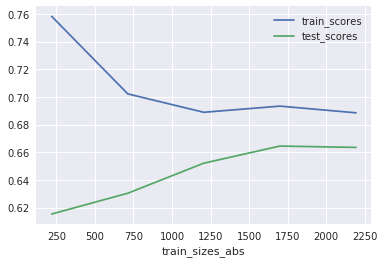

In [180]:
# [UserWarning about columns and attribute while plotting in Jupyter](https://github.com/pandas-dev/pandas/issues/18671)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    learning_curve_to_data_frame(pl3_lc).plot(x='train_sizes_abs',y=['train_scores', 'test_scores'])

In [181]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    pl2_lc = sklearn.model_selection.learning_curve(pl2, X, y, cv=sklearn.model_selection.ShuffleSplit(n_splits=3, random_state=42))

In [182]:
learning_curve_to_data_frame(pl2_lc)

,train_sizes_abs,train_scores,test_scores
0,219,0.861875,-0.130688
1,713,0.811364,0.500111
2,1206,0.783311,0.641843
3,1700,0.780630,0.717359
4,2194,0.776168,0.744026


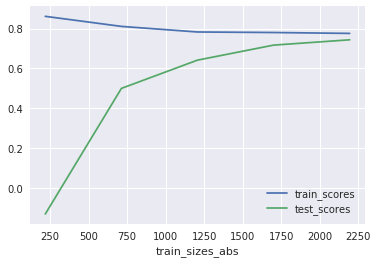

In [183]:
# [UserWarning about columns and attribute while plotting in Jupyter](https://github.com/pandas-dev/pandas/issues/18671)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    learning_curve_to_data_frame(pl2_lc).plot(x='train_sizes_abs',y=['train_scores', 'test_scores'])

<a id='section-tree-random-forest-regression'></a>

## Tree / Random Forest Regression

In [184]:
import sklearn.ensemble

In [185]:
it = dsbasics.bin.MetaDataInitTransformer()

dc = dsbasics.bin.DropColumnTransformer(['PID', 'Alley'])

ct = dsbasics.bin.CategoricalTransformer(
    categorical_columns = cat_columns,
    ordered_categorical_columns = [c for c,vs in cat_columns_ordinal],
    discrete_columns = discrete_columns, 
    continuous_columns = continuous_columns, 
    levels_map = category_definition_levels_map
)

nt = dsbasics.bin.NullToNATransformer(null_to_NA_columns = tmp_cat_columns_NA)

lt = dsbasics.bin.CategoryLevelsAsStringsTransformer()

trat = dsbasics.bin.TreeRegressorAdapterTransformer(
    categorical_columns = cat_columns,
    ordered_categorical_columns = [c for c,vs in cat_columns_ordinal],
    discrete_columns=discrete_columns, 
    continuous_columns=continuous_columns
)

pl_trat = sklearn.pipeline.Pipeline(
    memory=None,
    steps=[
        ('init', it),
        ('drop_columns', dc),
        ('ct', ct),
        ('null_to_NA', nt),
        ('levels_as_strings', lt),
        ('tree_regressor_adapter', trat),
])

rf_X0 = pl_trat.fit_transform(df_pipeline_input.iloc[:,:-1], df_pipeline_input.SalePrice)
rf_X0[df_pipeline_input.SalePrice.name] = df_pipeline_input.SalePrice
rf_X0.head()

,Lot_Frontage,Lot_Area,Lot_Shape,Utilities,Land_Slope,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating_QC,Electrical,X1st_Flr_SF,X2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,X3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Val,Mo_Sold,Yr_Sold,Condition_2_Norm,Condition_2_Feedr,Condition_2_PosA,Condition_2_PosN,Condition_2_Artery,Condition_2_RRNn,Condition_2_RRAe,Condition_2_RRAn,Roof_Matl_CompShg,Roof_Matl_WdShake,Roof_Matl_Tar&Grv,Roof_Matl_WdShngl,Roof_Matl_Membran,Roof_Matl_ClyTile,Roof_Matl_Roll,Roof_Matl_Metal,Foundation_CBlock,Foundation_PConc,Foundation_Wood,Foundation_BrkTil,Foundation_Slab,Foundation_Stone,Roof_Style_Hip,Roof_Style_Gable,Roof_Style_Mansard,Roof_Style_Gambrel,Roof_Style_Shed,Roof_Style_Flat,Heating_GasA,Heating_GasW,Heating_Grav,Heating_Wall,Heating_Floor,Heating_OthW,Central_Air_Y,Central_Air_N,Neighborhood_NAmes,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_NWAmes,Neighborhood_Somerst,Neighborhood_BrDale,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_Blmngtn,Neighborhood_NoRidge,Neighborhood_SawyerW,Neighborhood_Sawyer,Neighborhood_Greens,Neighborhood_BrkSide,Neighborhood_OldTown,Neighborhood_IDOTRR,Neighborhood_ClearCr,Neighborhood_SWISU,Neighborhood_Edwards,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Blueste,Neighborhood_Mitchel,Neighborhood_Timber,Neighborhood_MeadowV,Neighborhood_Veenker,Neighborhood_GrnHill,Neighborhood_Landmrk,Mas_Vnr_Type_Stone,Mas_Vnr_Type_None,Mas_Vnr_Type_BrkFace,Mas_Vnr_Type_BrkCmn,Mas_Vnr_Type_CBlock,Sale_Type_WD,Sale_Type_New,Sale_Type_COD,Sale_Type_ConLI,Sale_Type_Con,Sale_Type_ConLD,Sale_Type_Oth,Sale_Type_ConLw,Sale_Type_CWD,Sale_Type_VWD,Land_Contour_Lvl,Land_Contour_HLS,Land_Contour_Bnk,Land_Contour_Low,Exterior_1st_BrkFace,Exterior_1st_VinylSd,Exterior_1st_Wd Sdng,Exterior_1st_CemntBd,Exterior_1st_HdBoard,Exterior_1st_Plywood,Exterior_1st_MetalSd,Exterior_1st_AsbShng,Exterior_1st_WdShing,Exterior_1st_Stucco,Exterior_1st_AsphShn,Exterior_1st_BrkComm,Exterior_1st_CBlock,Exterior_1st_PreCast,Exterior_1st_Stone,Exterior_1st_ImStucc,MS_Zoning_RL,MS_Zoning_RH,MS_Zoning_FV,MS_Zoning_RM,MS_Zoning_C (all),MS_Zoning_I (all),MS_Zoning_A (agr),Garage_Type_Attchd,Garage_Type_Detchd,Garage_Type_BuiltIn,Garage_Type_Basment,Garage_Type_2Types,Garage_Type_CarPort,Garage_Type_NA,Exterior_2nd_Plywood,Exterior_2nd_VinylSd,Exterior_2nd_Wd Sdng,Exterior_2nd_BrkFace,Exterior_2nd_CmentBd,Exterior_2nd_HdBoard,Exterior_2nd_Wd Shng,Exterior_2nd_MetalSd,Exterior_2nd_ImStucc,Exterior_2nd_Brk Cmn,Exterior_2nd_AsbShng,Exterior_2nd_Stucco,Exterior_2nd_AsphShn,Exterior_2nd_CBlock,Exterior_2nd_Stone,Exterior_2nd_PreCast,Exterior_2nd_Other,MS_SubClass_020,MS_SubClass_030,MS_SubClass_040,MS_SubClass_045,MS_SubClass_050,MS_SubClass_060,MS_SubClass_070,MS_SubClass_075,MS_SubClass_080,MS_SubClass_085,MS_SubClass_090,MS_SubClass_120,MS_SubClass_150,MS_SubClass_160,MS_SubClass_180,MS_SubClass_190,Condition_1_Norm,Condition_1_Feedr,Condition_1_PosN,Condition_1_RRNe,Condition_1_RRAe,Condition_1_Artery,Condition_1_PosA,Condition_1_RRAn,Condition_1_RRNn,Lot_Config_Corner,Lot_Config_Inside,Lot_Config_CulDSac,Lot_Config_FR2,Lot_Config_FR3,Sale_Condition_Normal,Sale_Condition_Partial,Sale_Condition_Family,Sale_Condition_Abnorml,Sale_Condition_Alloca,Sale_Condition_AdjLand,Street_Pave,Street_Grvl,House_Style_1Story,House_Style_2Story,House_Style_1.5Fin,House_Style_SFoyer,House_Style_SLvl,House_Style_2.5Unf,House_Style_1.5Unf,House_Style_2.5Fin,Bldg_Type_1Fam,Bldg_Type_TwnhsE,Bldg_Type_Twnhs,Bldg_Type_Duplex,Bldg_Type_2fmCon,Misc_Feature_Shed,Misc_Feature_Gar2,Mi

In [186]:
rf_X0.shape

(2438, 244)

In [187]:
(df.SalePrice.loc[rf_X0.index] == rf_X0.SalePrice).all()

True

In [188]:
rf_X1 = rf_X0.iloc[:,:-1]
rf_y  = rf_X0.SalePrice

In [189]:
rf_clf = sklearn.ensemble.RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
rf_clf.fit(rf_X1, rf_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [190]:
rf_clf.score(rf_X1, rf_y)

0.9871506585026385

In [191]:
lds = pd.Series(name='feature_imporances')
for name, score in zip(rf_X1.columns, rf_clf.feature_importances_):
    lds.loc[name] = score
lds.sort_values(ascending=False).iloc[:30]

Overall_Qual      0.666372
Gr_Liv_Area       0.097837
Total_Bsmt_SF     0.027867
X1st_Flr_SF       0.022028
BsmtFin_SF_1      0.018016
Lot_Area          0.015810
Year_Built        0.015444
X2nd_Flr_SF       0.014773
Full_Bath         0.009556
Garage_Area       0.009306
Garage_Cars       0.007003
Lot_Frontage      0.006765
Year_Remod_Add    0.006468
Open_Porch_SF     0.005146
Kitchen_Qual      0.004278
Garage_Yr_Blt     0.003880
Bsmt_Unf_SF       0.003866
Bsmt_Qual         0.003654
Mas_Vnr_Area      0.003615
Mo_Sold           0.003216
Wood_Deck_SF      0.003144
BsmtFin_Type_1    0.002964
Overall_Cond      0.002901
Fireplace_Qu      0.002470
Garage_Finish     0.002201
Fireplaces        0.002123
Bsmt_Exposure     0.001981
Screen_Porch      0.001970
TotRms_AbvGrd     0.001494
Exter_Qual        0.001300
Name: feature_imporances, dtype: float64

In [192]:
mbn.arc_strength_info().iloc[:10,:]

,from,to,strength,rs,rmif,rmit
0,SalePrice,Neighborhood,-1086.172919,1.000000,0.344832,0.153247
1,SalePrice,Overall_Qual,-963.928136,0.887454,0.306023,0.429010
2,SalePrice,Garage_Cars,-814.157718,0.749565,0.258474,0.339345
3,SalePrice,Bsmt_Qual,-780.101563,0.718211,0.247662,0.341725
4,SalePrice,Exter_Qual,-759.623713,0.699358,0.241161,0.392364
5,SalePrice,Kitchen_Qual,-725.805718,0.668223,0.230425,0.329908
6,SalePrice,Garage_Area,-707.446379,0.651320,0.224596,0.280044
7,SalePrice,Year_Built,-684.115062,0.629840,0.217189,0.302669
8,SalePrice,Gr_Liv_Area,-627.594653,0.577804,0.199245,0.266564
9,SalePrice,Garage_Yr_Blt,-606.238457,0.558142,0.192465,0.262437


In [193]:
scoring = {'r2': 'r2',
           'neg_median_absolute_error': 'neg_median_absolute_error'
          }
scores = sklearn.model_selection.cross_validate(rf_clf, rf_X1, rf_y, scoring=scoring, 
                                                cv=sklearn.model_selection.ShuffleSplit(n_splits=10, random_state=0), 
                                                return_train_score=True)
rf_scores_df0 = pd.DataFrame(scores)
rf_scores_df = pd.DataFrame()
rf_scores_df['test_median_absolute_error'] = -rf_scores_df0['test_neg_median_absolute_error']
rf_scores_df['train_median_absolute_error'] = -rf_scores_df0['train_neg_median_absolute_error']
rf_scores_df['test_r2'] = rf_scores_df0['test_r2']
rf_scores_df['train_r2'] = rf_scores_df0['train_r2']
rf_scores_df

,test_median_absolute_error,train_median_absolute_error,test_r2,train_r2
0,9931.193333,3501.653000,0.900805,0.986266
1,11562.774000,3534.811333,0.921004,0.986873
2,9919.924000,3619.417000,0.928966,0.986336
3,10918.303000,3386.122000,0.920108,0.987291
4,9846.309000,3523.077000,0.910393,0.987763
5,8947.278000,3505.408000,0.905277,0.987518
6,9471.230000,3563.556000,0.863508,0.986959
7,10810.334000,3534.323000,0.940576,0.986415
8,9398.403000,3522.449000,0.935818,0.987342
9,11188.491000,3410.427000,0.912545,0.986864


In [194]:
rf_scores_df.test_median_absolute_error.mean()

10199.423933333335

In [195]:
rf_scores_df.test_r2.mean()

0.9139000146725442